In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nashpy as nash
import itertools
import cvxpy as cp
import cvxopt
from tqdm import tqdm
import seaborn as sb
from scipy.stats import skewnorm
from scipy.optimize import minimize
import pickle

In [3]:
def savePickle(var, name):
    with open(name+'.pickle', 'wb') as handle:
        pickle.dump(var, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def openPickle(name):
    filename = name+'.pickle'
    with open(filename,'rb') as f:
        var = pickle.load(f)
    return var

In [6]:
filename = 'spinning_top_payoffs.pkl'
with open(filename, 'rb') as f:
    payoffs = pickle.load(f)

Game name: 10,3-Blotto
Number of strategies: 66



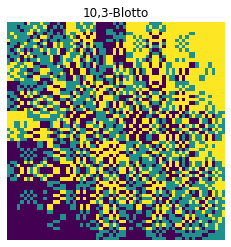

Game name: 10,4-Blotto
Number of strategies: 286



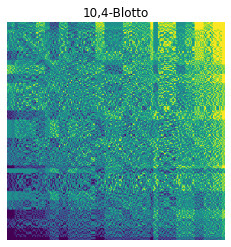

Game name: 10,5-Blotto
Number of strategies: 1001



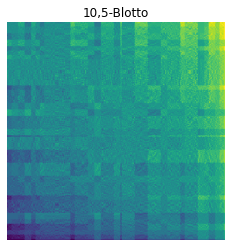

Game name: 3-move parity game 2
Number of strategies: 160



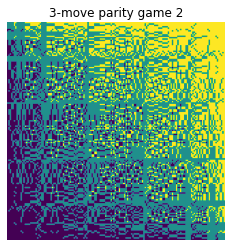

Game name: 5,3-Blotto
Number of strategies: 21



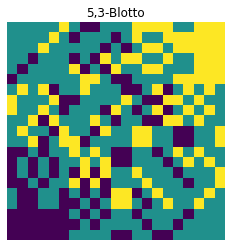

Game name: 5,4-Blotto
Number of strategies: 56



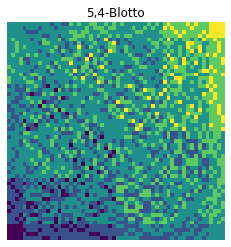

Game name: 5,5-Blotto
Number of strategies: 126



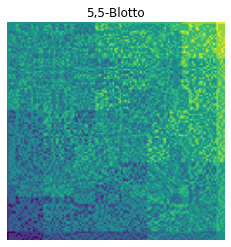

Game name: AlphaStar
Number of strategies: 888



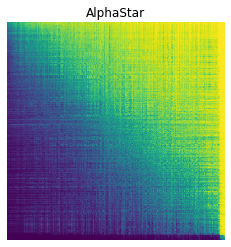

Game name: Blotto
Number of strategies: 1001



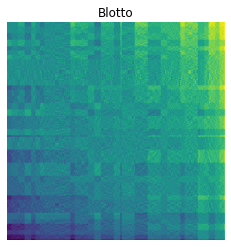

Game name: Disc game
Number of strategies: 1000



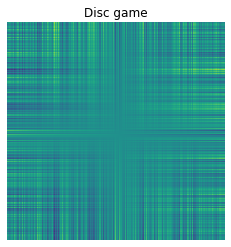

Game name: Elo game + noise=0.1
Number of strategies: 1000



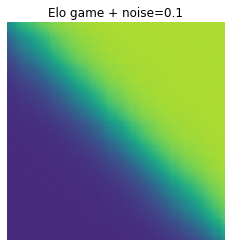

Game name: Elo game + noise=0.5
Number of strategies: 1000



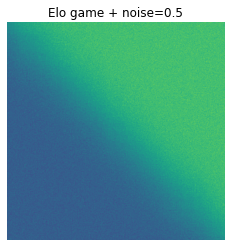

Game name: Elo game + noise=1.0
Number of strategies: 1000



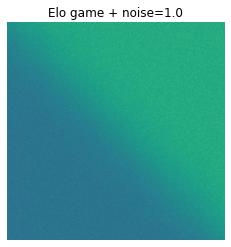

Game name: Elo game
Number of strategies: 1000



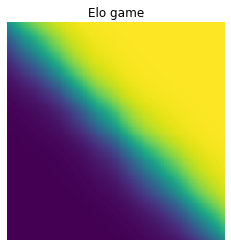

Game name: Kuhn-poker
Number of strategies: 64



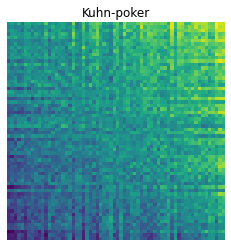

Game name: Normal Bernoulli game
Number of strategies: 1000



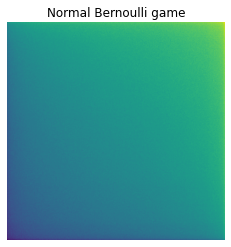

Game name: RPS
Number of strategies: 3



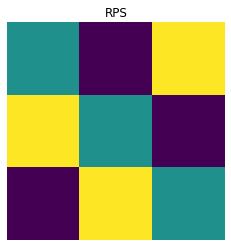

Game name: Random game of skill
Number of strategies: 1000



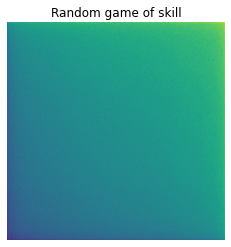

Game name: Transitive game
Number of strategies: 1000



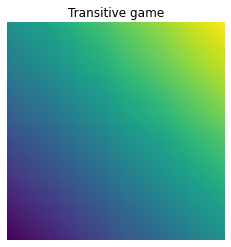

Game name: Triangular game
Number of strategies: 1000



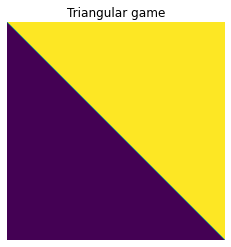

Game name: connect_four
Number of strategies: 1470



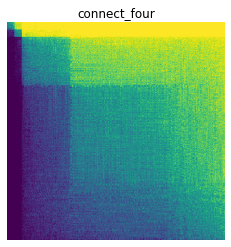

Game name: go(board_size=3,komi=6.5)
Number of strategies: 1933



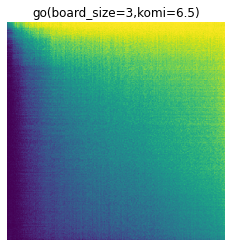

Game name: go(board_size=4,komi=6.5)
Number of strategies: 1679



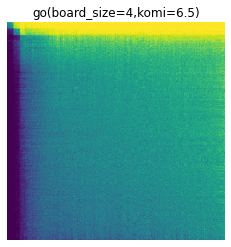

Game name: hex(board_size=3)
Number of strategies: 766



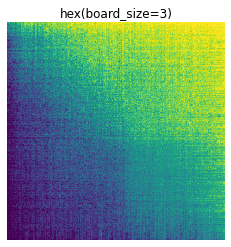

Game name: misere(game=tic_tac_toe())
Number of strategies: 926



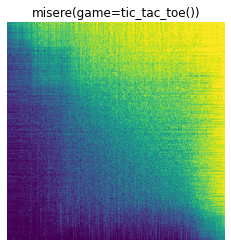

Game name: quoridor(board_size=3)
Number of strategies: 1404



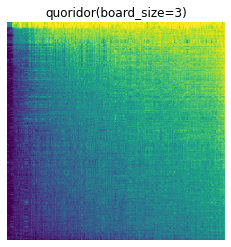

Game name: quoridor(board_size=4)
Number of strategies: 1540



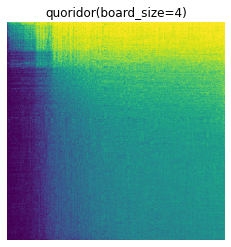

Game name: tic_tac_toe
Number of strategies: 880



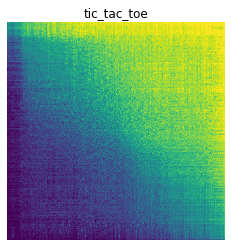

In [7]:
# Iterate over games
for game_name in payoffs:
    print(f"Game name: {game_name}")
    print(f"Number of strategies: {payoffs[game_name].shape[0]}")
    print()
    
    # Sort strategies by mean winrate for nice presentation
    order = np.argsort(-payoffs[game_name].mean(1))

    # Plot the payoff
    plt.figure()
    plt.title(game_name)
    plt.imshow(payoffs[game_name][order, :][:, order])
    plt.axis('off')
    plt.show()
    plt.close()

In [8]:
# Functions
def create_payoff(n, bin_lb, bin_ub):
    # Construct payoff template and bins
    # Also returns marker array, to indicate whether one missing, both missing, or none missing
    bins = np.array(create_bins(bin_lb, bin_ub, n))
    payoff = np.ones((n, n)) * -8; np.fill_diagonal(payoff, 0)
    
    # Marker matrix to indicate missing data. 1 for both present, -1 for p1 white, -2 for p1 black, -3 for both series
    mat = np.zeros((n, n))
    
    for i in tqdm(range(len(bins))):
        for j in range(len(bins)):
           # These are actually p1 and p2 ratings. We want to find where this p1 rating is white vs p2 black and
            # then vice versa
            p1_bin_lb, p1_bin_ub = bins[i]
            p2_bin_lb, p2_bin_ub = bins[j] 
            
            # Mid-bin rating to predict if missing
            p1_rating = (p1_bin_ub + p1_bin_lb) / 2
            p2_rating = (p2_bin_ub + p2_bin_lb) / 2
            
            if p1_bin_lb >= p2_bin_lb:
                continue
            else:
                # Sieve off data
                p1_white = (df['white_elo'] < p1_bin_ub) & (df['white_elo'] >= p1_bin_lb)
                p2_white = (df['white_elo'] < p2_bin_ub) & (df['white_elo'] >= p2_bin_lb)

                p1_black = (df['black_elo'] < p1_bin_ub) & (df['black_elo'] >= p1_bin_lb)
                p2_black = (df['black_elo'] < p2_bin_ub) & (df['black_elo'] >= p2_bin_lb)

                # Count data available
                p1_white_counts = np.sum(p1_white); p1_black_counts = np.sum(p1_black)
                p2_white_counts = np.sum(p2_white); p2_black_counts = np.sum(p2_black)

                # bool_ser1 = p1 white and p2 black; bool_ser2 = p1 black and p2 white
                bool_ser1 = p1_white & p2_black; bool_ser2 = p1_black & p2_white
                ser1_count = np.sum(bool_ser1); ser2_count = np.sum(bool_ser2)

                if ser1_count != 0 and ser2_count != 0:
                    # Both matchups exist in data
                    # To get average, must put a - b, since if black wins, result is -1. Payoff matrix
                    # is wrt to player 1
                    value = (np.mean(df[bool_ser1]['result']) - np.mean(df[bool_ser2]['result'])) / 2
                    payoff[i,j] = value
                    payoff[j,i] = -value
                    mat[i,j] = 1; mat[j,i] = 1
                else:
                    if ser1_count !=0 and ser2_count == 0:
                        # i.e. series 2 matchup don't exist. Hence series 1 use real data
#                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, series 2 missing")
                        ser1_rate = np.mean(df[bool_ser1]['result'])

                        # Predict series 2 with elo. This don't care who is white/black
                        # NOTE: win probability is probability of player 1 winning, yielding a reward of +1
                        # To find expected score, must multiply probability with score
                        win_prob = win_rate_elo(p1_rating, p2_rating)
                        ser2_rate = win_prob * 1 + (1 - win_prob) * -1
                
                        value = (ser1_rate + ser2_rate) / 2
                        payoff[i,j] = value
                        payoff[j,i] = -value
                        mat[i,j] = -2
                        mat[j,i] = -2

                    if ser1_count == 0 and ser2_count != 0:
                        # i.e. series 1 matchup don't exist. Hence series 2 use real data
#                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, series 1 missing")
                        win_prob = win_rate_elo(p1_rating, p2_rating)
                        ser1_rate = win_prob * 1 + (1 - win_prob) * -1
                        ser2_rate = np.mean(df[bool_ser2]['result'])
                        value = (ser1_rate - ser2_rate) / 2
                        payoff[i,j] = value
                        payoff[j,i] = -value
                        mat[i,j] = -1; mat[j,i] = -1

                    if ser1_count == 0 and ser2_count == 0:
#                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, both missing")
                        # i.e. both are missing, predict using elo
                        win_prob = win_rate_elo(p1_rating, p2_rating)
                        value = win_prob * 1 + (1 - win_prob) * (-1)
                        payoff[i,j] = value
                        payoff[j,i] = -value
                        mat[i,j] = -3; mat[j,i] = -3
                        
    return payoff, mat


def create_payoff_2(white_bins, black_bins):
    # Construct payoff template and bins
    # Also returns marker array, to indicate whether one missing, both missing, or none missing
    n_row = len(white_bins); n_col = len(black_bins)
    payoff = np.ones((n_row, n_col)) * -8; np.fill_diagonal(payoff, 0)
    
    # Marker matrix to indicate missing data. 1 for both present, -1 for p1 white, -2 for p1 black, -3 for both series
    mat = np.zeros((n_row, n_col))
    
    for i in tqdm(range(n_row)):
        for j in range(range(n_col)):
           # These are actually p1 and p2 ratings. We want to find where this p1 rating is white vs p2 black and
            # then vice versa
            p1_bin_lb, p1_bin_ub = white_bins[i]
            p2_bin_lb, p2_bin_ub = black_bins[j]
            
            # Mid-bin rating to predict if missing
            p1_rating = (p1_bin_ub + p1_bin_lb) / 2
            p2_rating = (p2_bin_ub + p2_bin_lb) / 2
            
            if p1_bin_lb >= p2_bin_lb:
                continue
            else:
                # Sieve off data
                p1_white = (df['white_elo'] < p1_bin_ub) & (df['white_elo'] >= p1_bin_lb)
                p2_white = (df['white_elo'] < p2_bin_ub) & (df['white_elo'] >= p2_bin_lb)

                p1_black = (df['black_elo'] < p1_bin_ub) & (df['black_elo'] >= p1_bin_lb)
                p2_black = (df['black_elo'] < p2_bin_ub) & (df['black_elo'] >= p2_bin_lb)

                # Count data available
                p1_white_counts = np.sum(p1_white); p1_black_counts = np.sum(p1_black)
                p2_white_counts = np.sum(p2_white); p2_black_counts = np.sum(p2_black)

                # bool_ser1 = p1 white and p2 black; bool_ser2 = p1 black and p2 white
                bool_ser1 = p1_white & p2_black; bool_ser2 = p1_black & p2_white
                ser1_count = np.sum(bool_ser1); ser2_count = np.sum(bool_ser2)

                if ser1_count != 0 and ser2_count != 0:
                    # Both matchups exist in data
                    # To get average, must put a - b, since if black wins, result is -1. Payoff matrix
                    # is wrt to player 1
                    value = (np.mean(df[bool_ser1]['result']) - np.mean(df[bool_ser2]['result'])) / 2
                    payoff[i,j] = value
                    payoff[j,i] = -value
                    mat[i,j] = 1; mat[j,i] = 1
                else:
                    if ser1_count !=0 and ser2_count == 0:
                        # i.e. series 2 matchup don't exist. Hence series 1 use real data
#                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, series 2 missing")
                        ser1_rate = np.mean(df[bool_ser1]['result'])

                        # Predict series 2 with elo. This don't care who is white/black
                        # NOTE: win probability is probability of player 1 winning, yielding a reward of +1
                        # To find expected score, must multiply probability with score
                        win_prob = win_rate_elo(p1_rating, p2_rating)
                        ser2_rate = win_prob * 1 + (1 - win_prob) * -1
                
                        value = (ser1_rate + ser2_rate) / 2
                        payoff[i,j] = value
                        payoff[j,i] = -value
                        mat[i,j] = -2
                        mat[j,i] = -2

                    if ser1_count == 0 and ser2_count != 0:
                        # i.e. series 1 matchup don't exist. Hence series 2 use real data
#                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, series 1 missing")
                        win_prob = win_rate_elo(p1_rating, p2_rating)
                        ser1_rate = win_prob * 1 + (1 - win_prob) * -1
                        ser2_rate = np.mean(df[bool_ser2]['result'])
                        value = (ser1_rate - ser2_rate) / 2
                        payoff[i,j] = value
                        payoff[j,i] = -value
                        mat[i,j] = -1; mat[j,i] = -1

                    if ser1_count == 0 and ser2_count == 0:
#                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, both missing")
                        # i.e. both are missing, predict using elo
                        win_prob = win_rate_elo(p1_rating, p2_rating)
                        value = win_prob * 1 + (1 - win_prob) * (-1)
                        payoff[i,j] = value
                        payoff[j,i] = -value
                        mat[i,j] = -3; mat[j,i] = -3
                        
    return payoff, mat
            
class NashCluster():
    
    def __init__(self, strat_payoffs, ori_idx, pvect):
        self.size = strat_payoffs.shape[0]
        self.payoffs = strat_payoffs
        self.strat_idx = ori_idx
        self.probability = pvect
        
    def computeRPS(self):
        return None
    
def solve_MaxEnt_NE(payoff, verbose = False, eps = 1e-5, zero_tol = 1e-6, iters = 500, cycle = 5):
    
    init_val = np.random.uniform(size = payoff.shape[0])
    init_val = init_val / np.sum(init_val)
    
    p = cp.Variable(payoff.shape[0], value = init_val)
    constraints = [payoff @ p <= 0, cp.sum(p) == 1, p >= 0]
    objective = cp.sum(cp.entr(p))
    prob = cp.Problem(cp.Maximize(objective), constraints)
    
    try:
      cycle_count = 0; done = False
      while cycle_count < cycle and done is False:
        prob.solve(verbose = verbose, solver = cp.MOSEK, warm_start = True)
        p_vect = p.value * (p.value > zero_tol)
        diff = payoff @ p_vect.reshape(-1, 1)
        print(f"Cycle count {cycle_count}, diff = {np.sum(diff >= eps)}")
        done = True if np.sum(diff >= eps) == 0 else False
        cycle_count += 1
    except cp.SolverError:
      print("MOSEK FAILED?")
      try:
        # Try ECOS_BB first
        cycle_count = 0; done = False
        while cycle_count < cycle and done is False:
          prob.solve(verbose = verbose, max_iters = 1000, solver = cp.ECOS_BB, warm_start = True)
          p_vect = p.value * (p.value > zero_tol)
          diff = payoff @ p_vect.reshape(-1, 1)
          print(f"Cycle count {cycle_count}, diff = {np.sum(diff >= eps)}")
          done = True if np.sum(diff >= eps) == 0 else False
          cycle_count += 1
      except cp.SolverError:
        print("ECOS_BB FAILED")
        cycle_count = 0; done = False
        while cycle_count < cycle and done is False:
          prob.solve(verbose = verbose, max_iters = iters, solver = cp.SCS, warm_start = True)
          p_vect = p.value * (p.value > zero_tol)
          diff = payoff @ p_vect.reshape(-1, 1)
          print(f"Cycle count {cycle_count}, diff = {np.sum(diff >= eps)}")
          done = True if np.sum(diff >= eps) == 0 else False
          cycle_count += 1
  
    # Clean - small values
    p_vect = p_vect * (p_vect > zero_tol)
    return p_vect, np.sum(diff>=eps)
    
def Nash_Clustering(payoff, marker, algo = "cvx", eps = 1e-4, zero_tol = 1e-8):
    n_strat = payoff.shape[0]; counter = 0;

    # This is the remaining payoff and the remaining strategy indexes
    curr_payoff = payoff; curr_remaining = np.arange(n_strat); curr_marker = marker
    nash_clusters = []; unsolved_cases = []; marker_instances = []

    while n_strat > 1: # if only 1 strategy remaining, this itself is the nash cluster
        print(f"Iteration {counter}")

        # # Compute the NE supports. Lemke Howson seems the fastest
        # game = nash.Game(curr_payoff + np.eye(curr_payoff.shape[0]) * 1e-10)
        # if algo == "Lemke":
        #     nash_eqs = game.lemke_howson_enumeration()
        #     nash_eq = np.array(next(nash_eqs)[0])

        # if algo == 'Support': # slow because enumerates all possible NE supports
        #     nash_eqs = game.support_enumeration()
        #     nash_eq = np.array(next(nash_eqs)[0])

        # if algo == 'Vertex':
        #     nash_eqs = game.vertex_enumeration()
        #     nash_eq = np.array(next(nash_eqs)[0])

        if algo == 'cvx': # solve using cvxpy, seems to be the only one working for now
            nash_eq, diff = solve_MaxEnt_NE(curr_payoff, eps =1e-4, zero_tol = zero_tol, iters = int(2e4), cycle = 5)
            print(f"Outside, diff = {diff}")
            p_vect = nash_eq[nash_eq >= zero_tol]
#             if diff > -10:
#               print("APPENDING UNSOLVED CASE")
#               unsolved_cases.append(curr_payoff)
#               marker_instances.append(curr_marker)

        # Take the supports, exclude them in the next round payoffs
        taken_strat = np.where(nash_eq >= zero_tol)[0]; remaining_strat = np.where(nash_eq < zero_tol)[0]
        
        if len(taken_strat) != len(p_vect):
            print("WTF")
            print(taken_strat, p_vect)
        taken_idx = np.array(list(itertools.product(taken_strat, repeat = 2)))
        remaining_idx = np.array(list(itertools.product(remaining_strat, repeat = 2)))

        strat_payoffs = payoff[taken_idx[:,0], taken_idx[:, 1]].reshape(taken_strat.shape[0], taken_strat.shape[0])
        nash_clusters.append(NashCluster(strat_payoffs, curr_remaining[taken_strat], p_vect))

        # Get the remaining payoff. If statement here to prevent cases when remaining_idx is empty and [:,0] wont work
        if len(remaining_strat) > 0:
          curr_payoff = curr_payoff[remaining_idx[:,0], remaining_idx[:,1]].reshape(remaining_strat.shape[0], remaining_strat.shape[0])
          curr_remaining = curr_remaining[remaining_strat]
          curr_marker = curr_marker[remaining_idx[:,0], remaining_idx[:,1]].reshape(remaining_strat.shape[0], remaining_strat.shape[0])

        n_strat -= strat_payoffs.shape[0]

        counter += 1
        print(f"Strategies left {n_strat}")
        print(f"Payoff remaining size {curr_payoff.shape[0]}") 

    if n_strat == 1:
        nash_clusters.append(NashCluster(curr_payoff, curr_remaining, np.array([1])))

    return nash_clusters, marker_instances, unsolved_cases

def plot_results(nash_clusters, title):
  nc_sizes = []
  for nc in nash_clusters:
      nc_sizes.append(nc.size)

  y_ax = np.linspace(1, 0, len(nc_sizes))
  plt.scatter(nc_sizes, y_ax)
  plt.title(title)
  plt.ylabel('Fraction Beaten')
  plt.xlabel('Cluster Size')

def compute_RPP(nc1, nc2, payoff):
    p_vect1 = np.zeros(payoff.shape[0]); p_vect2 = np.zeros(payoff.shape[0])
    
    p_vect1[nc1.strat_idx] = nc1.probability; p_vect2[nc2.strat_idx] = nc2.probability
    return (p_vect1.reshape(1, -1) @ payoff @ p_vect2.reshape(-1, 1)).item()
    
def generate_RPP_data(nash_clusters, payoff):
    data_tuples_rpp = []; n_nc = len(nash_clusters); data_tuples_rpp_sign = []; rpp_mat = np.zeros((n_nc, n_nc))
    for i, nc_i in enumerate(nash_clusters):
        rpp_sum = 0; rpp_sign_sum = 0
        for j, nc_j in enumerate(nash_clusters):
            if i != j:
                rpp = compute_RPP(nc_i, nc_j, payoff)
                rpp_mat[i,j] = rpp
                rpp_sum += rpp
                rpp_sign_sum += 1 * (rpp >= 0)

        rpp_sum = rpp_sum / n_nc; rpp_sign_sum = rpp_sign_sum / (n_nc - 1)

        data_tuples_rpp.append([nc_i.size, rpp_sum])
        data_tuples_rpp_sign.append([nc_i.size, rpp_sign_sum])

    return np.array(data_tuples_rpp), np.array(data_tuples_rpp_sign), rpp_mat

def generate_RPS_data(payoff):
    signed_payoff = 1 * (payoff > 0)
    strat_winrate = np.mean(payoff > 0, axis = 1)
    adj = signed_payoff @ signed_payoff @ signed_payoff
    
    return np.diag(adj), strat_winrate

def plot_RPS(adj, strat_winrate, title):
    plt.title(title)
    plt.xlabel('RPS Cycles')
    plt.ylabel('Mean Win-Rate')
    plt.scatter(adj, strat_winrate)
    
def plot_nash_clusters_2(sign_rpp, title):
    plt.scatter(sign_rpp[:, 0], sign_rpp[:, 1])
    plt.title(title)
    plt.ylabel('Fraction Beaten (RPP)')
    plt.xlabel('Cluster Size')
    
def plot_nash_clusters_3(sign_rpp, title, seed = 88):
    plt.scatter(sign_rpp[:, 0], sign_rpp[:, 1])
    plt.title(title)
    plt.ylabel('Fraction Beaten (RPP)')
    plt.xlabel('Cluster Size')
    
    # Fit skewed normal
    np.random.seed(seed)
    y_data = sign_rpp[:, 0]; x_data = sign_rpp[:, 1]
    init = np.random.uniform(1, 3, size = (5))
    params = fit_skewed_normal(init, x_data, y_data)
    
    inputs = np.linspace(0, 1, 1000)
    outputs = affine_skewed_normal_pdf(params, inputs)
    plt.plot(outputs, inputs)
    
    return params
    
# Test using scipy.optimize.minimize. Need a function to minimize with signature function(x, *args), where x is a list
# of the parameters to optimize. Syntax: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
def affine_skewed_normal_loss(parameters, xdata, ydata):
    """
    parameters shape is [\mu, \sigma, \alpha, \a, \b]
    """
    mu, sigma, alpha, a, b = parameters
    
    # Compute the loss
    out = a * (sigma ** 2) * skewnorm.pdf(xdata, alpha, mu, sigma**2) + b
#     out = a * skewnorm.pdf(xdata, alpha, mu, sigma) + b
    loss = np.sum((out - ydata) ** 2)
    
    return loss

def affine_skewed_normal_pdf(parameters, xdata):
    mu, sigma, alpha, a, b = parameters
    out = a * (sigma ** 2) * skewnorm.pdf(xdata, alpha, mu, sigma**2) + b
#     out = a * skewnorm.pdf(xdata, alpha, mu, sigma) + b
    return out

def fit_skewed_normal(init, xdata, ydata):
    bnds = [(None, None), (1e-15, None), (None, None), (None, None), (None, None)]
    results = minimize(affine_skewed_normal_loss, init, args = (xdata, ydata), bounds = bnds, tol = 1e-8)
    return results.x

def savePickle(var, name):
    with open(name+'.pickle', 'wb') as handle:
        pickle.dump(var, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def openPickle(name):
    filename = name+'.pickle'
    with open(filename,'rb') as f:
        var = pickle.load(f)
    return var

def generate_elo_nc_data(nash_clusters, lower_bound, upper_bound, n):
    bins = create_bins(lower_bound, upper_bound, n)
    mid_bins = np.mean(np.array(bins), axis = 1)
    data = []
    
    for nc in nash_clusters:
        ori_idx = nc.strat_idx
        av_elo = np.mean(mid_bins[ori_idx])
        data.append([nc.size, av_elo])
    
    return np.array(data)

def plot_elo_nc(data, title):
    plt.title(title)
    plt.xlabel('Nash Cluster Size')
    plt.ylabel('Average Elo')
    plt.scatter(data[:,0], data[:, 1])
    
def compute_win_rate(curr_idx, payoff):
    return np.mean(payoff[curr_idx, :]) 

In [12]:
# With Uniform

def compute_win_rate(curr_idx, payoff):
    return np.mean(payoff[curr_idx, :])

def generate_training_data(payoff, pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300, 350]):
    win_rates_results = dict()

    for pop_size in pop_sizes:
        print(f"Population Size {pop_size}")
        win_rates = []
        strat_strengths = np.mean(payoff > 0, axis = 1)
        ordering_idx = np.argsort(strat_strengths)

        curr_strat_idx = list(ordering_idx[:pop_size])
        win_rates.append(compute_win_rate(curr_strat_idx, payoff))
        n_iters = 2000; it = 0
        converge = False
        while it < n_iters:
            taken_payoff = np.sum(payoff[:, curr_strat_idx], axis = 1)
            viable_strats = np.where(taken_payoff > 0)[0]
            not_in = ~np.isin(viable_strats, curr_strat_idx)
            viable_strats = viable_strats[not_in]
            if len(viable_strats) > 0:
                viable_strengths = strat_strengths[viable_strats]
                sorted_idx = np.argsort(viable_strengths)
                new_strat = viable_strats[sorted_idx[0]]
                curr_strat_idx.append(new_strat)
                curr_strat_idx = curr_strat_idx[1:]
            else:
                if converge == False:
                    converge = True
                    it_conv = it
                    print(f"First Reached Peak at {it_conv}")


            win_rates.append(compute_win_rate(curr_strat_idx, payoff))
            it += 1

        if converge == False:
            print(f"Population size {pop_size} doesn't converge")
            
        win_rates_results[pop_size] = win_rates
    
    return win_rates_results

def plot_training(win_rates_results, title, save = False):
    plt.figure(figsize = (10,8))
    plt.title(title)
    for pop_size in win_rates_results.keys():
        win_rates = win_rates_results[pop_size]
        plt.plot(np.arange(len(win_rates)), win_rates, label = str(pop_size))
        
    plt.xlabel('Iterations')
    plt.ylabel('Mean Win Rate')
    plt.legend(title = 'Population Size')
    
    if save:
        plt.savefig('Training Plots.pdf')

In [13]:
# With Nash
def compute_win_rate(curr_idx, payoff):
    return np.mean(payoff[curr_idx, :])

def compute_win_rate3(curr_strat_idx, payoff):
    # With Nash
    pop_size = len(curr_strat_idx)
    taken_idx = np.array(list(itertools.product(curr_strat_idx, repeat = 2)))
    taken_payoff = payoff[taken_idx[:, 0], taken_idx[:, 1]].reshape(pop_size, pop_size)
    p_vect, _ = solve_MaxEnt_NE(taken_payoff)
    prob_vect = np.zeros((payoff.shape[0]))
    prob_vect[curr_strat_idx] = p_vect
    return np.mean(prob_vect.reshape(1, -1) @ payoff)

def generate_training_data3(payoff, pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300, 350]):
    win_rates_results = dict()

    for pop_size in pop_sizes:
        print(f"Population Size {pop_size}")
        win_rates = []
        strat_strengths = np.mean(payoff > 0, axis = 1)
        ordering_idx = np.argsort(strat_strengths)

        curr_strat_idx = list(ordering_idx[:pop_size])
        if pop_size == 1:
            win_rates.append(compute_win_rate(curr_strat_idx, payoff))
        else:
            win_rates.append(compute_win_rate3(curr_strat_idx, payoff))
        n_iters = 2000; it = 0
        converge = False; prev_win_rate = 0
        while it < n_iters:
            taken_payoff = np.sum(payoff[:, curr_strat_idx], axis = 1)
            viable_strats = np.where(taken_payoff > 0)[0]
            not_in = ~np.isin(viable_strats, curr_strat_idx)
            viable_strats = viable_strats[not_in]
            if len(viable_strats) > 0:
                viable_strengths = strat_strengths[viable_strats]
                sorted_idx = np.argsort(viable_strengths)
                new_strat = viable_strats[sorted_idx[0]]
                curr_strat_idx.append(new_strat)
                curr_strat_idx = curr_strat_idx[1:]
            else:
                if converge == False:
                    converge = True
                    it_conv = it
                    print(f"First Reached Peak at {it_conv}")

            if pop_size == 1:
                win_rates.append(compute_win_rate(curr_strat_idx, payoff))
            else:
                if converge:
                    win_rates.append(prev_win_rate)
                else:
                    prev_win_rate = compute_win_rate3(curr_strat_idx, payoff)
                    win_rates.append(prev_win_rate)
                    
            it += 1

        if converge == False:
            print(f"Population size {pop_size} doesn't converge")
            
        win_rates_results[pop_size] = win_rates
    
    return win_rates_results

def solve_MaxEnt_NE(payoff, verbose = False, eps = 1e-5, zero_tol = 1e-6, iters = 500, cycle = 5):
    
    init_val = np.random.uniform(size = payoff.shape[0])
    init_val = init_val / np.sum(init_val)
    
    p = cp.Variable(payoff.shape[0], value = init_val)
    constraints = [payoff @ p <= 0, cp.sum(p) == 1, p >= 0]
    objective = cp.sum(cp.entr(p))
    prob = cp.Problem(cp.Maximize(objective), constraints)
    
    try:
      cycle_count = 0; done = False
      while cycle_count < cycle and done is False:
        prob.solve(verbose = verbose, solver = cp.MOSEK, warm_start = True)
        p_vect = p.value * (p.value > zero_tol)
        diff = payoff @ p_vect.reshape(-1, 1)
#         print(f"Cycle count {cycle_count}, diff = {np.sum(diff >= eps)}")
        done = True if np.sum(diff >= eps) == 0 else False
        cycle_count += 1
    except cp.SolverError:
      print("MOSEK FAILED?")
      try:
        # Try ECOS_BB first
        cycle_count = 0; done = False
        while cycle_count < cycle and done is False:
          prob.solve(verbose = verbose, max_iters = 1000, solver = cp.ECOS_BB, warm_start = True)
          p_vect = p.value * (p.value > zero_tol)
          diff = payoff @ p_vect.reshape(-1, 1)
#           print(f"Cycle count {cycle_count}, diff = {np.sum(diff >= eps)}")
          done = True if np.sum(diff >= eps) == 0 else False
          cycle_count += 1
      except cp.SolverError:
        print("ECOS_BB FAILED")
        cycle_count = 0; done = False
        while cycle_count < cycle and done is False:
          prob.solve(verbose = verbose, max_iters = iters, solver = cp.SCS, warm_start = True)
          p_vect = p.value * (p.value > zero_tol)
          diff = payoff @ p_vect.reshape(-1, 1)
#           print(f"Cycle count {cycle_count}, diff = {np.sum(diff >= eps)}")
          done = True if np.sum(diff >= eps) == 0 else False
          cycle_count += 1
  
    # Clean - small values
    p_vect = p_vect * (p_vect > zero_tol)
    return p_vect, np.sum(diff>=eps)

In [9]:
payoffs.keys()

dict_keys(['10,3-Blotto', '10,4-Blotto', '10,5-Blotto', '3-move parity game 2', '5,3-Blotto', '5,4-Blotto', '5,5-Blotto', 'AlphaStar', 'Blotto', 'Disc game', 'Elo game + noise=0.1', 'Elo game + noise=0.5', 'Elo game + noise=1.0', 'Elo game', 'Kuhn-poker', 'Normal Bernoulli game', 'RPS', 'Random game of skill', 'Transitive game', 'Triangular game', 'connect_four', 'go(board_size=3,komi=6.5)', 'go(board_size=4,komi=6.5)', 'hex(board_size=3)', 'misere(game=tic_tac_toe())', 'quoridor(board_size=3)', 'quoridor(board_size=4)', 'tic_tac_toe'])

### Quoridor 4 x  4

In [10]:
payoff = payoffs['quoridor(board_size=4)']
marker = np.ones(payoff.shape)

In [11]:
nash_clusters, markers_instances, unsolved_cases = Nash_Clustering(payoff, marker)

Iteration 0
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1524
Payoff remaining size 1524
Iteration 1
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1501
Payoff remaining size 1501
Iteration 2
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1474
Payoff remaining size 1474
Iteration 3
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1453
Payoff remaining size 1453
Iteration 4
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1433
Payoff remaining size 1433
Iteration 5
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1409
Payoff remaining size 1409
Iteration 6
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1389
Payoff remaining size 1389
Iteration 7
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1371
Payoff remaining size 1371
Iteration 8
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1356
Payoff remaining size 1356
Iteration 9
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1340
Payoff 

In [14]:
_, data, _ = generate_RPP_data(nash_clusters, payoff)

In [15]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
uniform_training = generate_training_data(payoff, pop_sizes)

Population Size 1
Population size 1 doesn't converge
Population Size 25
Population size 25 doesn't converge
Population Size 50
Population size 50 doesn't converge
Population Size 75
Population size 75 doesn't converge
Population Size 100
Population size 100 doesn't converge
Population Size 150
Population size 150 doesn't converge
Population Size 200
Population size 200 doesn't converge
Population Size 250
Population size 250 doesn't converge
Population Size 300
First Reached Peak at 1495


In [16]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
nash_training = generate_training_data3(payoff, pop_sizes)

Population Size 1
Population size 1 doesn't converge
Population Size 25
Population size 25 doesn't converge
Population Size 50
Population size 50 doesn't converge
Population Size 75
Population size 75 doesn't converge
Population Size 100
Population size 100 doesn't converge
Population Size 150
Population size 150 doesn't converge
Population Size 200
Population size 200 doesn't converge
Population Size 250
Population size 250 doesn't converge
Population Size 300
First Reached Peak at 1495


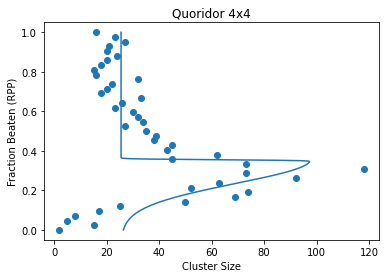

In [23]:
seed = 8888888
params = plot_nash_clusters_3(data, 'Quoridor 4x4', seed)

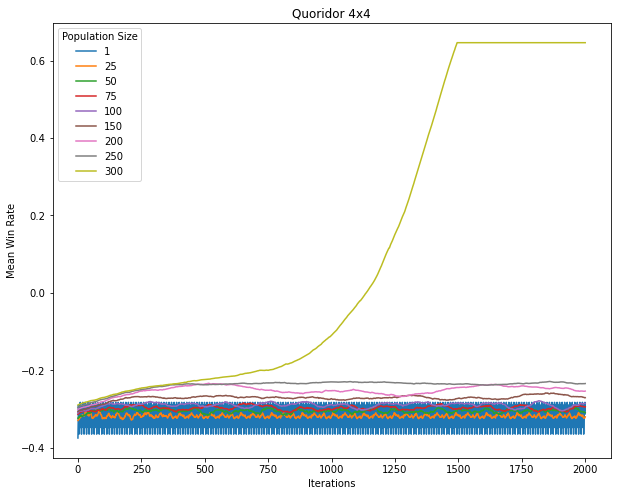

In [25]:
plot_training(uniform_training, 'Quoridor 4x4')

In [24]:
savePickle(params, 'Quoridor 4x4 NC Params')
savePickle(nash_clusters, 'Quoridor 4x4 Nash Clusters')
savePickle(uniform_training, 'Quoridor 4x4 Uniform Training')
savePickle(nash_training, 'Quoridor 4x4 Nash Training')

### Connect Four

In [26]:
payoff = payoffs['connect_four']
marker = np.ones(payoff.shape)

In [27]:
nash_clusters, markers_instances, unsolved_cases = Nash_Clustering(payoff, marker)

Iteration 0
Outside, diff = 0
Strategies left 1446
Payoff remaining size 1446
Iteration 1
Outside, diff = 0
Strategies left 1432
Payoff remaining size 1432
Iteration 2
Outside, diff = 0
Strategies left 1428
Payoff remaining size 1428
Iteration 3
Outside, diff = 0
Strategies left 1421
Payoff remaining size 1421
Iteration 4
Outside, diff = 0
Strategies left 1419
Payoff remaining size 1419
Iteration 5
Outside, diff = 0
Strategies left 1397
Payoff remaining size 1397
Iteration 6
Outside, diff = 0
Strategies left 1382
Payoff remaining size 1382
Iteration 7
Outside, diff = 0
Strategies left 1372
Payoff remaining size 1372
Iteration 8
Outside, diff = 0
Strategies left 1367
Payoff remaining size 1367
Iteration 9
Outside, diff = 0
Strategies left 1360
Payoff remaining size 1360
Iteration 10
Outside, diff = 0
Strategies left 1324
Payoff remaining size 1324
Iteration 11
Outside, diff = 0
Strategies left 1289
Payoff remaining size 1289
Iteration 12
Outside, diff = 0
Strategies left 1257
Payoff rem

In [28]:
_, data, _ = generate_RPP_data(nash_clusters, payoff)

In [29]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
uniform_training = generate_training_data(payoff, pop_sizes)

Population Size 1
Population size 1 doesn't converge
Population Size 25
Population size 25 doesn't converge
Population Size 50
Population size 50 doesn't converge
Population Size 75
Population size 75 doesn't converge
Population Size 100
Population size 100 doesn't converge
Population Size 150
Population size 150 doesn't converge
Population Size 200
Population size 200 doesn't converge
Population Size 250
Population size 250 doesn't converge
Population Size 300
First Reached Peak at 1260


In [30]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
nash_training = generate_training_data3(payoff, pop_sizes)

Population Size 1
Population size 1 doesn't converge
Population Size 25
Population size 25 doesn't converge
Population Size 50
Population size 50 doesn't converge
Population Size 75
Population size 75 doesn't converge
Population Size 100
Population size 100 doesn't converge
Population Size 150
Population size 150 doesn't converge
Population Size 200
Population size 200 doesn't converge
Population Size 250
Population size 250 doesn't converge
Population Size 300
First Reached Peak at 1260


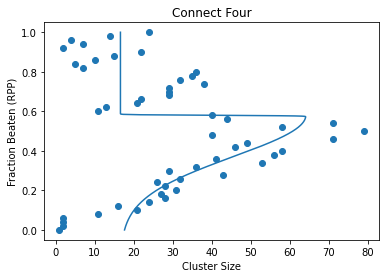

In [38]:
seed = 8888888
params = plot_nash_clusters_3(data, 'Connect Four', seed)

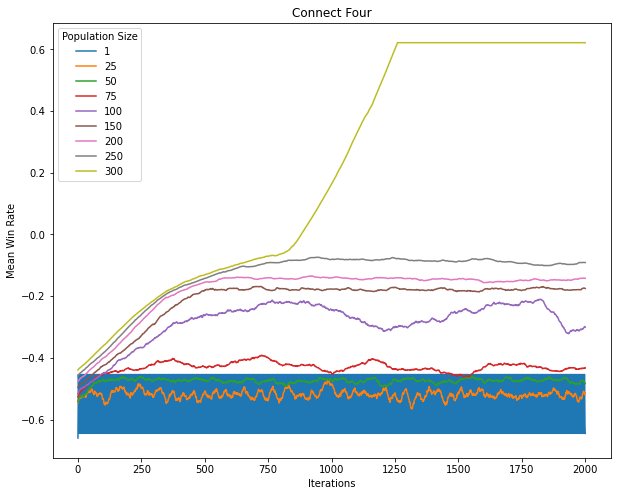

In [41]:
plot_training(uniform_training, 'Connect Four')

In [42]:
savePickle(params, 'Connect Four NC Params')
savePickle(nash_clusters, 'Connect Four Nash Clusters')
savePickle(uniform_training, 'Connect Four Uniform Training')
savePickle(nash_training, 'Connect Four Nash Training')

### Quoridor 3x3

In [51]:
payoff = payoffs['quoridor(board_size=3)']
marker = np.ones(payoff.shape)

In [52]:
nash_clusters, markers_instances, unsolved_cases = Nash_Clustering(payoff, marker)

Iteration 0
Outside, diff = 0
Strategies left 1368
Payoff remaining size 1368
Iteration 1
Outside, diff = 0
Strategies left 1363
Payoff remaining size 1363
Iteration 2
Outside, diff = 0
Strategies left 1358
Payoff remaining size 1358
Iteration 3
Outside, diff = 0
Strategies left 1345
Payoff remaining size 1345
Iteration 4
Outside, diff = 0
Strategies left 1331
Payoff remaining size 1331
Iteration 5
Outside, diff = 0
Strategies left 1318
Payoff remaining size 1318
Iteration 6
Outside, diff = 0
Strategies left 1286
Payoff remaining size 1286
Iteration 7
Outside, diff = 0
Strategies left 1278
Payoff remaining size 1278
Iteration 8
Outside, diff = 0
Strategies left 1259
Payoff remaining size 1259
Iteration 9
Outside, diff = 0
Strategies left 1233
Payoff remaining size 1233
Iteration 10
Outside, diff = 0
Strategies left 1209
Payoff remaining size 1209
Iteration 11
Outside, diff = 0
Strategies left 1179
Payoff remaining size 1179
Iteration 12
Outside, diff = 0
Strategies left 1142
Payoff rem

In [53]:
_, data, _ = generate_RPP_data(nash_clusters, payoff)

In [54]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
uniform_training = generate_training_data(payoff, pop_sizes)

Population Size 1
Population size 1 doesn't converge
Population Size 25
Population size 25 doesn't converge
Population Size 50
Population size 50 doesn't converge
Population Size 75
Population size 75 doesn't converge
Population Size 100
Population size 100 doesn't converge
Population Size 150
Population size 150 doesn't converge
Population Size 200
Population size 200 doesn't converge
Population Size 250
First Reached Peak at 1541
Population Size 300
First Reached Peak at 1239


In [47]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
nash_training = generate_training_data3(payoff, pop_sizes)

Population Size 1
Population size 1 doesn't converge
Population Size 25
Population size 25 doesn't converge
Population Size 50
Population size 50 doesn't converge
Population Size 75
Population size 75 doesn't converge
Population Size 100
Population size 100 doesn't converge
Population Size 150
Population size 150 doesn't converge
Population Size 200
Population size 200 doesn't converge
Population Size 250
First Reached Peak at 1541
Population Size 300
First Reached Peak at 1239


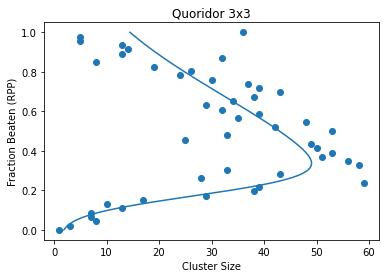

In [59]:
seed = 8
params = plot_nash_clusters_3(data, 'Quoridor 3x3', seed)

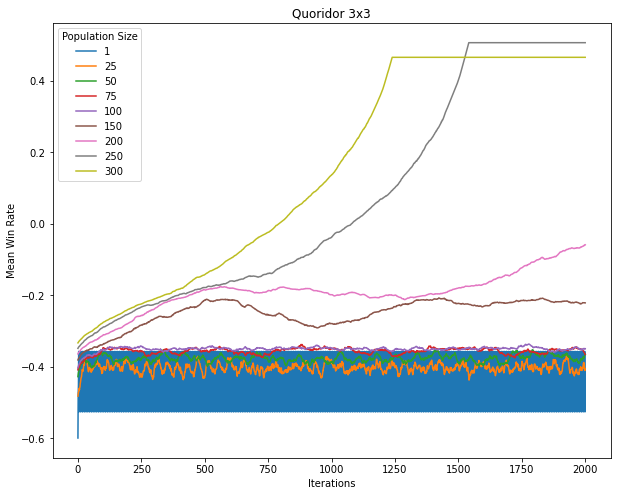

In [49]:
plot_training(uniform_training, 'Quoridor 3x3')

In [60]:
savePickle(params, 'Quoridor 3x3 NC Params')
savePickle(nash_clusters, 'Quoridor 3x3 Nash Clusters')
savePickle(uniform_training, 'Quoridor 3x3 Uniform Training')
# savePickle(nash_training, 'Quoridor 3x3 Nash Training')

### Tic Tac Toe Results

In [584]:
title = 'Tic Tac Toe'
payoff = payoffs['tic_tac_toe']
marker = np.ones(payoff.shape)
payoff.shape

(880, 880)

In [522]:
nash_clusters, markers_instances, unsolved_cases = Nash_Clustering(payoff, marker)

Iteration 0
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 872
Payoff remaining size 872
Iteration 1
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 853
Payoff remaining size 853
Iteration 2
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 845
Payoff remaining size 845
Iteration 3
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 831
Payoff remaining size 831
Iteration 4
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 824
Payoff remaining size 824
Iteration 5
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 809
Payoff remaining size 809
Iteration 6
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 796
Payoff remaining size 796
Iteration 7
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 777
Payoff remaining size 777
Iteratio

In [523]:
rpp_tuples, rpp_sign_tuples, rpp_mat = generate_RPP_data(nash_clusters, payoff)
adj, strat_winrate = generate_RPS_data(payoff)


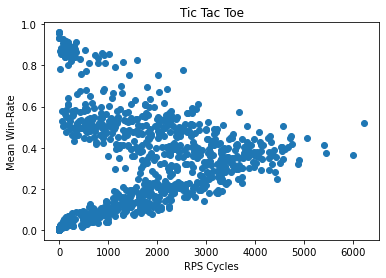

In [524]:
plot_RPS(adj, strat_winrate, title)

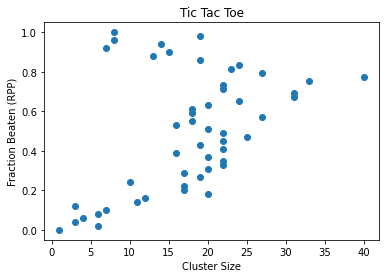

In [525]:
plot_nash_clusters_2(rpp_sign_tuples, title)

In [537]:
y_data = rpp_sign_tuples[:, 0]; x_data = rpp_sign_tuples[:, 1]
init = np.random.uniform(0, 2, size = (5)) + 2.5
print(init)
np.random.seed(88)
params = fit_skewed_normal(init, x_data, y_data)
print(params)

[2.61492019 4.35001487 3.81520308 2.76590568 3.56689785]
[ 0.52673324  1.04562639  7.08198961  9.33418168 16.27591869]


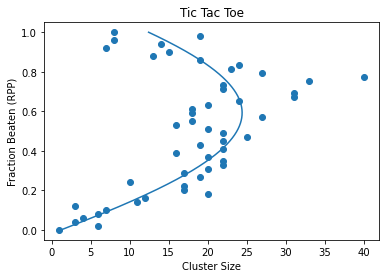

In [538]:
plot_nash_clusters_3(rpp_sign_tuples, title)

Population Size 1
Population size 1 doesn't converge
Population Size 25
Population size 25 doesn't converge
Population Size 50
Population size 50 doesn't converge
Population Size 75
First Reached Peak at 891
Population Size 100
First Reached Peak at 761
Population Size 150
First Reached Peak at 728
Population Size 200
First Reached Peak at 674
Population Size 250
First Reached Peak at 629
Population Size 300
First Reached Peak at 580


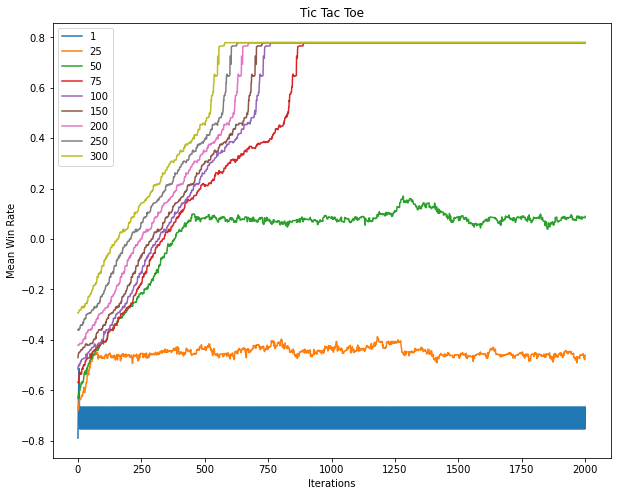

In [608]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
win_rates_results = generate_training_data3(payoff, pop_sizes)
plot_training(win_rates_results, title, pop_sizes)

### Misere Tic Tac Toe Results

In [611]:
title = 'Misere Tic Tac Toe'
payoff = payoffs['misere(game=tic_tac_toe())']
marker = np.ones(payoff.shape)
payoff.shape

(926, 926)

In [544]:
nash_clusters, markers_instances, unsolved_cases = Nash_Clustering(payoff, marker)

Iteration 0
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 921
Payoff remaining size 921
Iteration 1
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 904
Payoff remaining size 904
Iteration 2
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 895
Payoff remaining size 895
Iteration 3
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 883
Payoff remaining size 883
Iteration 4
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 872
Payoff remaining size 872
Iteration 5
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 858
Payoff remaining size 858
Iteration 6
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 840
Payoff remaining size 840
Iteration 7
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 820
Payoff remaining size 820
Iteratio

In [545]:
rpp_tuples, rpp_sign_tuples, rpp_mat = generate_RPP_data(nash_clusters, payoff)
adj, strat_winrate = generate_RPS_data(payoff)

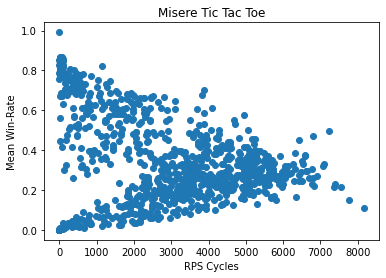

In [546]:
plot_RPS(adj, strat_winrate, title)

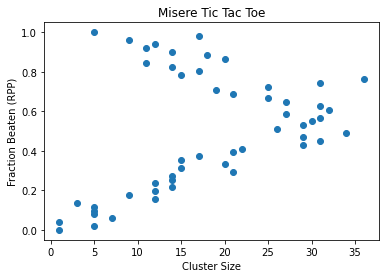

In [547]:
plot_nash_clusters_2(rpp_sign_tuples, title)

In [552]:
y_data = rpp_sign_tuples[:, 0]; x_data = rpp_sign_tuples[:, 1]
init = np.random.uniform(0, 2, size = (5)) + 2.5
print(init)
np.random.seed(8888)
params = fit_skewed_normal(init, x_data, y_data)
print(params)

[2.61492019 4.35001487 3.81520308 2.76590568 3.56689785]
[ 0.39114526  0.56772569  1.25048711 53.73713705  1.83825626]


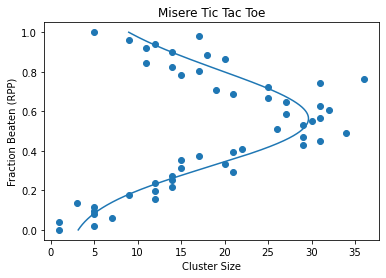

In [553]:
plot_nash_clusters_3(rpp_sign_tuples, title)

Population Size 1
Population size 1 doesn't converge
Population Size 25
Population size 25 doesn't converge
Population Size 50
Population size 50 doesn't converge
Population Size 75
First Reached Peak at 965
Population Size 100
First Reached Peak at 825
Population Size 150
First Reached Peak at 756
Population Size 200
First Reached Peak at 716
Population Size 250
First Reached Peak at 672
Population Size 300
First Reached Peak at 626


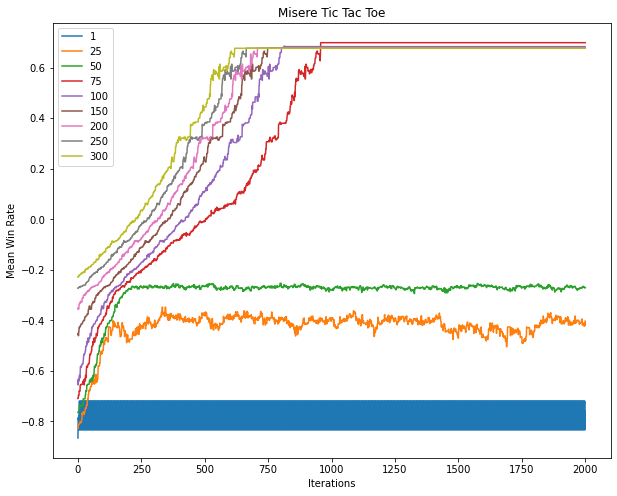

In [612]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
win_rates_results = generate_training_data3(payoff, pop_sizes)
plot_training(win_rates_results, title, pop_sizes)

### Connect Four Results

In [613]:
title = 'Connect Four'
payoff = payoffs['connect_four']
marker = np.ones(payoff.shape)
payoff.shape

(1470, 1470)

In [556]:
nash_clusters, markers_instances, unsolved_cases = Nash_Clustering(payoff, marker)

Iteration 0
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1446
Payoff remaining size 1446
Iteration 1
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1432
Payoff remaining size 1432
Iteration 2
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1428
Payoff remaining size 1428
Iteration 3
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1421
Payoff remaining size 1421
Iteration 4
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1419
Payoff remaining size 1419
Iteration 5
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1397
Payoff remaining size 1397
Iteration 6
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1382
Payoff remaining size 1382
Iteration 7
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1372
Payoff remaining si

In [557]:
rpp_tuples, rpp_sign_tuples, rpp_mat = generate_RPP_data(nash_clusters, payoff)
adj, strat_winrate = generate_RPS_data(payoff)

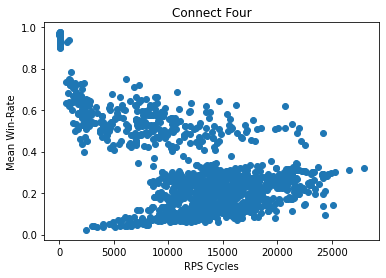

In [558]:
plot_RPS(adj, strat_winrate, title)

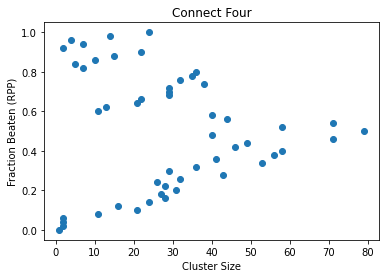

In [559]:
plot_nash_clusters_2(rpp_sign_tuples, title)

In [566]:
y_data = rpp_sign_tuples[:, 0]; x_data = rpp_sign_tuples[:, 1]
init = np.random.uniform(0, 2, size = (5)) + 2.5
print(init)
np.random.seed(88)
params = fit_skewed_normal(init, x_data, y_data)
print(params)

[3.31873485 3.32811894 3.06692942 3.3908144  2.97502329]
[   0.78077066    0.7084278  -405.07950986   40.3573225    11.12866735]


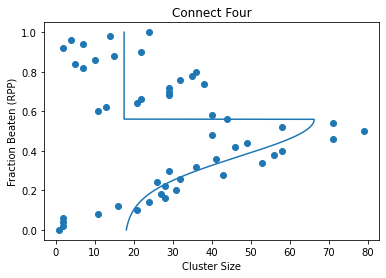

In [567]:
plot_nash_clusters_3(rpp_sign_tuples, title)

Population Size 1
Population size 1 doesn't converge
Population Size 25
Population size 25 doesn't converge
Population Size 50
Population size 50 doesn't converge
Population Size 75
Population size 75 doesn't converge
Population Size 100
Population size 100 doesn't converge
Population Size 150
Population size 150 doesn't converge
Population Size 200
Population size 200 doesn't converge
Population Size 250
Population size 250 doesn't converge
Population Size 300
First Reached Peak at 1382


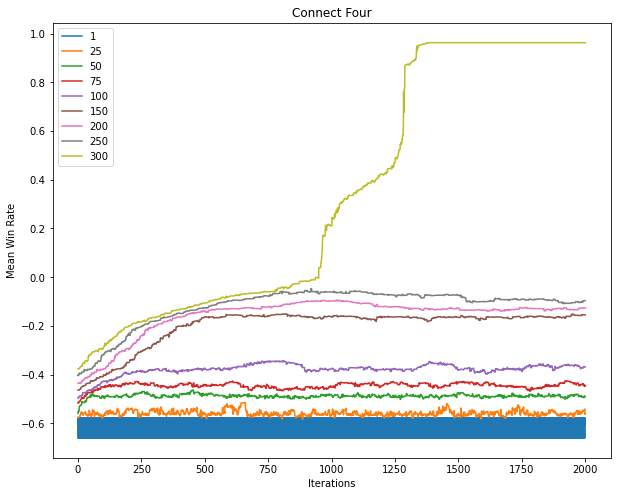

In [614]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
win_rates_results = generate_training_data3(payoff, pop_sizes)
plot_training(win_rates_results, title, pop_sizes)

### Hex 3x3

In [615]:
title = 'Hex Board Size 3'
payoff = payoffs['hex(board_size=3)']
marker = np.ones(payoff.shape)
payoff.shape

(766, 766)

In [570]:
nash_clusters, markers_instances, unsolved_cases = Nash_Clustering(payoff, marker)

Iteration 0
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 749
Payoff remaining size 749
Iteration 1
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 726
Payoff remaining size 726
Iteration 2
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 709
Payoff remaining size 709
Iteration 3
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 699
Payoff remaining size 699
Iteration 4
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 672
Payoff remaining size 672
Iteration 5
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 644
Payoff remaining size 644
Iteration 6
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 625
Payoff remaining size 625
Iteration 7
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 603
Payoff remaining size 603
Iteratio

In [571]:
rpp_tuples, rpp_sign_tuples, rpp_mat = generate_RPP_data(nash_clusters, payoff)
adj, strat_winrate = generate_RPS_data(payoff)

<AxesSubplot:title={'center':'Hex Board Size 3 RPP'}>

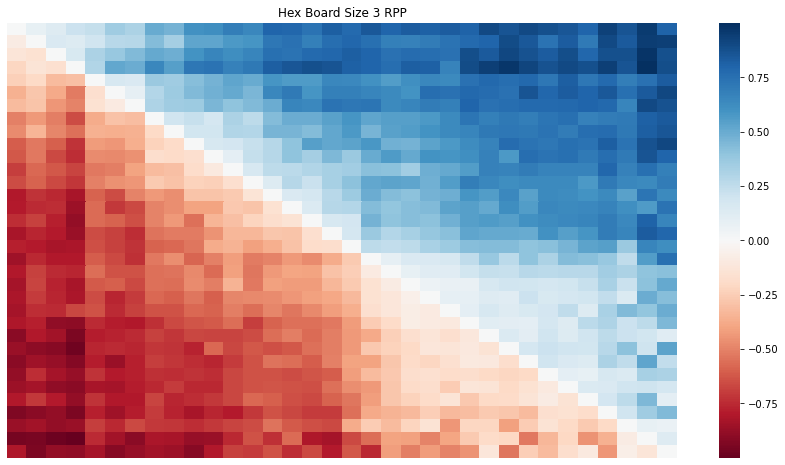

In [574]:
plt.figure(figsize = (15,8))
plt.title(title + " RPP")
sb.heatmap(rpp_mat, cmap = 'RdBu', xticklabels = False, yticklabels = False, annot = False)

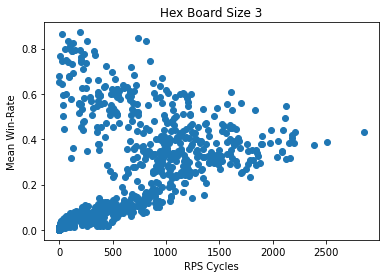

In [575]:
plot_RPS(adj, strat_winrate, title)

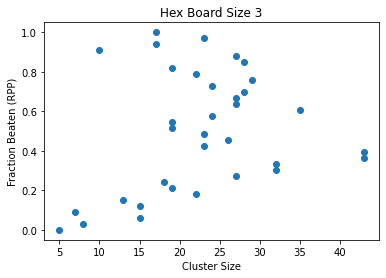

In [576]:
plot_nash_clusters_2(rpp_sign_tuples, title)

In [579]:
y_data = rpp_sign_tuples[:, 0]; x_data = rpp_sign_tuples[:, 1]
init = np.random.uniform(1, 5, size = (5))
print(init)
np.random.seed(8)
params = fit_skewed_normal(init, x_data, y_data)
print(params)

[3.85718841 3.86935353 1.89127785 1.70061809 2.82736595]
[ 0.20440437  0.77226975  7.92985162 28.88739071  8.71753665]


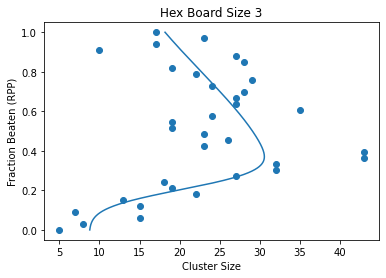

In [580]:
plot_nash_clusters_3(rpp_sign_tuples, title)

Population Size 1
Population size 1 doesn't converge
Population Size 25
Population size 25 doesn't converge
Population Size 50
Population size 50 doesn't converge
Population Size 75
First Reached Peak at 635
Population Size 100
First Reached Peak at 632
Population Size 150
First Reached Peak at 584
Population Size 200
First Reached Peak at 553
Population Size 250
First Reached Peak at 516
Population Size 300
First Reached Peak at 466


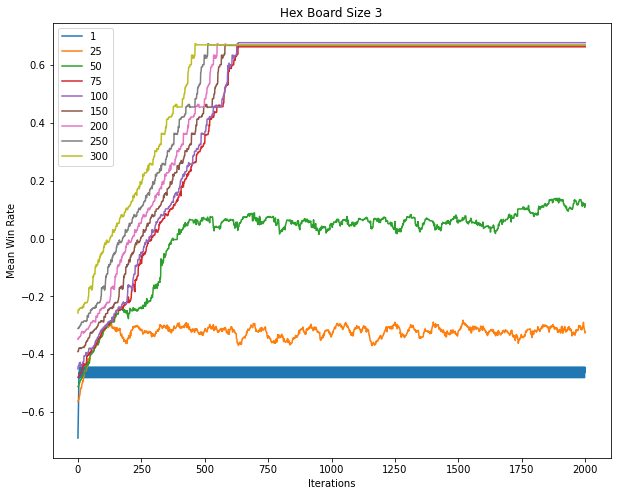

In [616]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
win_rates_results = generate_training_data3(payoff, pop_sizes)
plot_training(win_rates_results, title, pop_sizes)

### Go 3x3

In [617]:
title = 'Go Board Size 3'
payoff = payoffs['go(board_size=3,komi=6.5)']
marker = np.ones(payoff.shape)
payoff.shape

(1933, 1933)

In [618]:
nash_clusters, markers_instances, unsolved_cases = Nash_Clustering(payoff, marker)

Iteration 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1920
Payoff remaining size 1920
Iteration 1
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1906
Payoff remaining size 1906
Iteration 2
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1887
Payoff remaining size 1887
Iteration 3
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1871
Payoff remaining size 1871
Iteration 4
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1853
Payoff remaining size 1853
Iteration 5
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1835
Payoff remaining size 1835
Iteration 6
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1810
Payoff remaining size 1810
Iteration 7
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1790
Payoff remaining size 1790
Iteration 8
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1770
Payoff remaining size 1770
Iteration 9
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1737
Payoff 

In [619]:
rpp_tuples, rpp_sign_tuples, rpp_mat = generate_RPP_data(nash_clusters, payoff)
adj, strat_winrate = generate_RPS_data(payoff)

<AxesSubplot:title={'center':'Go Board Size 3 RPP'}>

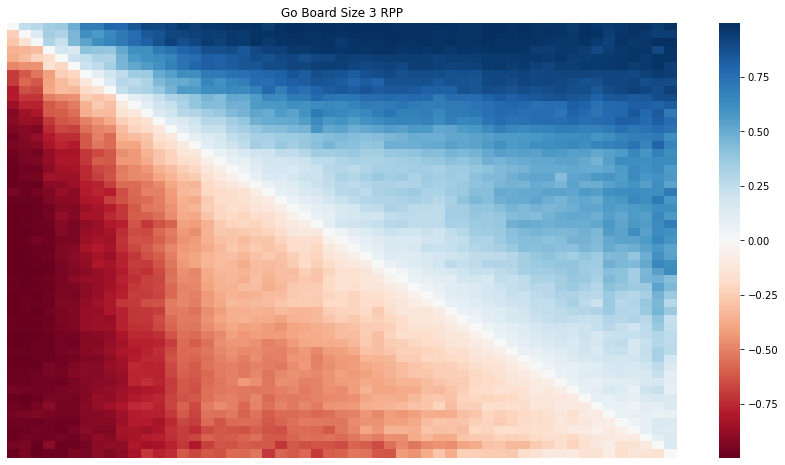

In [620]:
plt.figure(figsize = (15,8))
plt.title(title + " RPP")
sb.heatmap(rpp_mat, cmap = 'RdBu', xticklabels = False, yticklabels = False, annot = False)

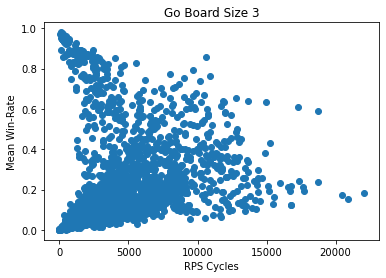

In [621]:
plot_RPS(adj, strat_winrate, title)

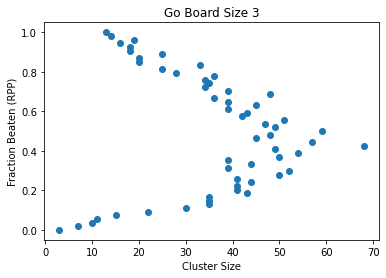

In [622]:
plot_nash_clusters_2(rpp_sign_tuples, title)

In [623]:
y_data = rpp_sign_tuples[:, 0]; x_data = rpp_sign_tuples[:, 1]
init = np.random.uniform(1, 5, size = (5))
print(init)
np.random.seed(8)
params = fit_skewed_normal(init, x_data, y_data)
print(params)

[1.92260296 1.58525393 1.97693707 2.65169304 3.83836464]
[   0.68740784    0.60342762 -174.69006408   35.75007749   22.94519562]


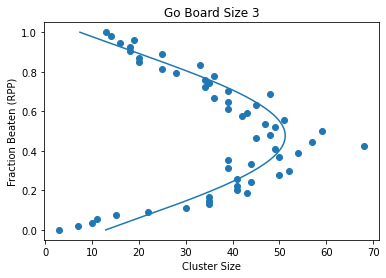

In [624]:
plot_nash_clusters_3(rpp_sign_tuples, title)

Population Size 1
Population size 1 doesn't converge
Population Size 25
Population size 25 doesn't converge
Population Size 50
Population size 50 doesn't converge
Population Size 75
Population size 75 doesn't converge
Population Size 100
Population size 100 doesn't converge
Population Size 150
Population size 150 doesn't converge
Population Size 200
Population size 200 doesn't converge
Population Size 250
First Reached Peak at 1786
Population Size 300
First Reached Peak at 1678


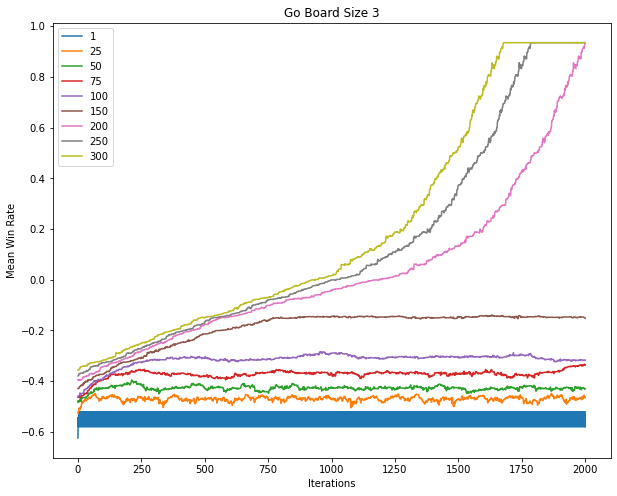

In [625]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
win_rates_results = generate_training_data3(payoff, pop_sizes)
plot_training(win_rates_results, title, pop_sizes)

### Quoridor 3x3

In [626]:
title = 'Quoridor Board Size 3'
payoff = payoffs['quoridor(board_size=3)']
marker = np.ones(payoff.shape)
payoff.shape

(1404, 1404)

In [627]:
nash_clusters, markers_instances, unsolved_cases = Nash_Clustering(payoff, marker)

Iteration 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1368
Payoff remaining size 1368
Iteration 1
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1363
Payoff remaining size 1363
Iteration 2
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1358
Payoff remaining size 1358
Iteration 3
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1345
Payoff remaining size 1345
Iteration 4
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1331
Payoff remaining size 1331
Iteration 5
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1318
Payoff remaining size 1318
Iteration 6
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1286
Payoff remaining size 1286
Iteration 7
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1278
Payoff remaining size 1278
Iteration 8
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1259
Payoff remaining size 1259
Iteration 9
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 1233
Payoff 

In [628]:
rpp_tuples, rpp_sign_tuples, rpp_mat = generate_RPP_data(nash_clusters, payoff)
adj, strat_winrate = generate_RPS_data(payoff)

<AxesSubplot:title={'center':'Quoridor Board Size 3 RPP'}>

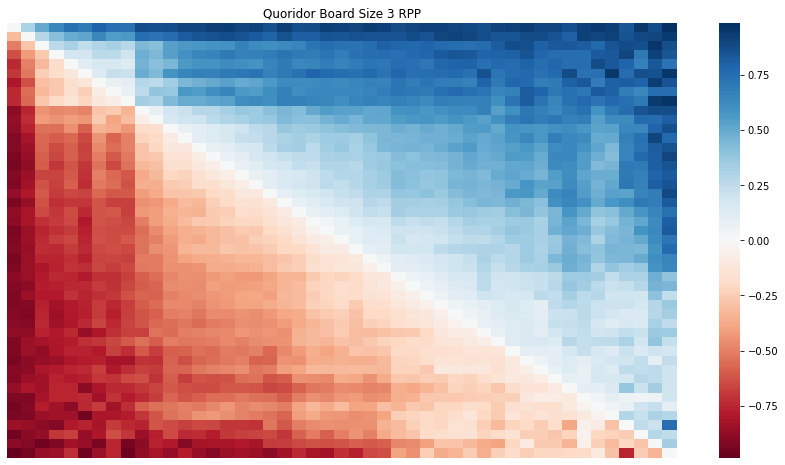

In [629]:
plt.figure(figsize = (15,8))
plt.title(title + " RPP")
sb.heatmap(rpp_mat, cmap = 'RdBu', xticklabels = False, yticklabels = False, annot = False)

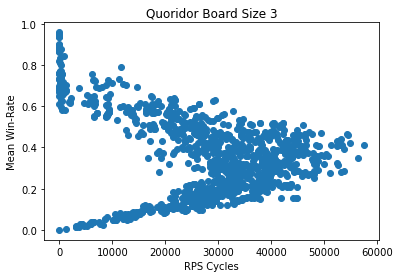

In [630]:
plot_RPS(adj, strat_winrate, title)

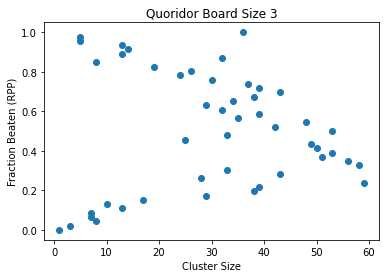

In [631]:
plot_nash_clusters_2(rpp_sign_tuples, title)

In [632]:
y_data = rpp_sign_tuples[:, 0]; x_data = rpp_sign_tuples[:, 1]
init = np.random.uniform(1, 5, size = (5))
print(init)
np.random.seed(8)
params = fit_skewed_normal(init, x_data, y_data)
print(params)

[3.614995   1.94667967 4.17449754 1.60681988 4.86992207]
[ 3.79852738  1.54298369  4.26975912  1.57234554 29.87233965]


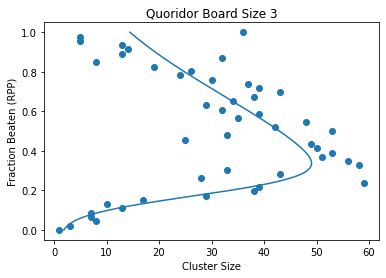

In [633]:
plot_nash_clusters_3(rpp_sign_tuples, title)

Population Size 1
Population size 1 doesn't converge
Population Size 25
Population size 25 doesn't converge
Population Size 50
Population size 50 doesn't converge
Population Size 75
Population size 75 doesn't converge
Population Size 100
Population size 100 doesn't converge
Population Size 150
Population size 150 doesn't converge
Population Size 200
Population size 200 doesn't converge
Population Size 250
First Reached Peak at 1337
Population Size 300
First Reached Peak at 1148


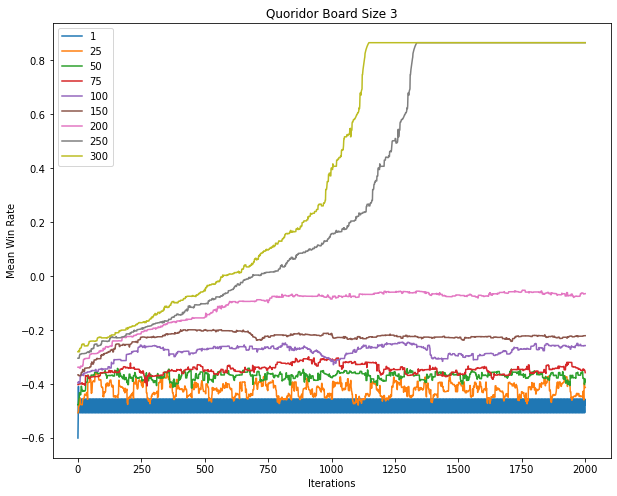

In [634]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
win_rates_results = generate_training_data3(payoff, pop_sizes)
plot_training(win_rates_results, title, pop_sizes)

### Alphastar

In [637]:
title = 'Alphastar'
payoff = payoffs['AlphaStar']
marker = np.ones(payoff.shape)
payoff.shape

(888, 888)

In [638]:
nash_clusters, markers_instances, unsolved_cases = Nash_Clustering(payoff, marker)

Iteration 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 882
Payoff remaining size 882
Iteration 1
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 874
Payoff remaining size 874
Iteration 2
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 868
Payoff remaining size 868
Iteration 3
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 859
Payoff remaining size 859
Iteration 4
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 853
Payoff remaining size 853
Iteration 5
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 842
Payoff remaining size 842
Iteration 6
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 833
Payoff remaining size 833
Iteration 7
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 821
Payoff remaining size 821
Iteration 8
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 812
Payoff remaining size 812
Iteration 9
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 802
Payoff remaining size 802


In [639]:
rpp_tuples, rpp_sign_tuples, rpp_mat = generate_RPP_data(nash_clusters, payoff)
adj, strat_winrate = generate_RPS_data(payoff)

<AxesSubplot:title={'center':'Alphastar RPP'}>

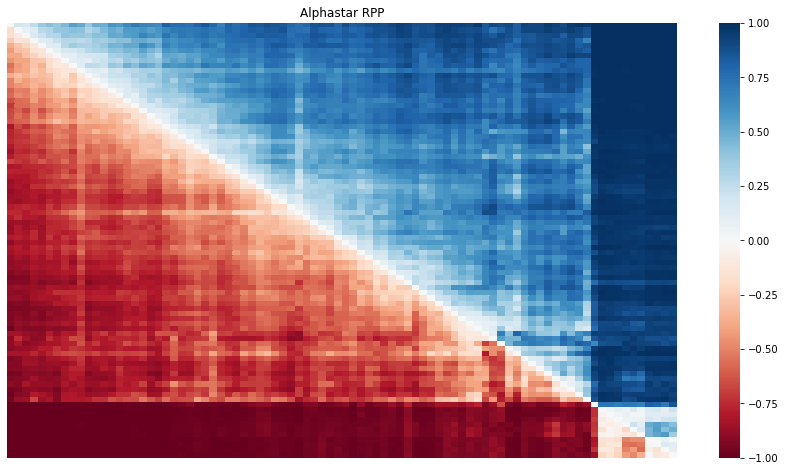

In [640]:
plt.figure(figsize = (15,8))
plt.title(title + " RPP")
sb.heatmap(rpp_mat, cmap = 'RdBu', xticklabels = False, yticklabels = False, annot = False)

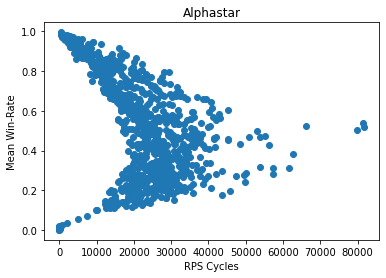

In [641]:
plot_RPS(adj, strat_winrate, title)

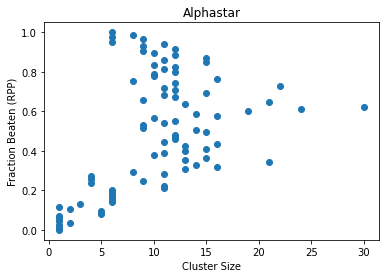

In [642]:
plot_nash_clusters_2(rpp_sign_tuples, title)

In [643]:
y_data = rpp_sign_tuples[:, 0]; x_data = rpp_sign_tuples[:, 1]
init = np.random.uniform(1, 5, size = (5))
print(init)
np.random.seed(8)
params = fit_skewed_normal(init, x_data, y_data)
print(params)

[4.32807933 2.2627304  4.23690927 4.28924004 2.17025636]
[  0.28784187   0.80118875   0.8544168   69.62340485 -17.79318045]


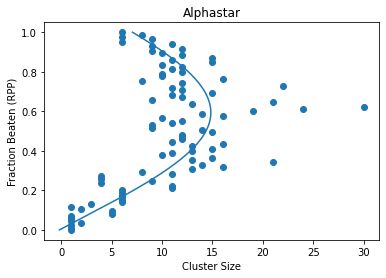

In [644]:
plot_nash_clusters_3(rpp_sign_tuples, title)

Population Size 1
Population size 1 doesn't converge
Population Size 25
Population size 25 doesn't converge
Population Size 50
MOSEK FAILED?
MOSEK FAILED?


C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Population size 50 doesn't converge
Population Size 75
First Reached Peak at 916
Population Size 100
First Reached Peak at 810
Population Size 150
First Reached Peak at 749
Population Size 200
First Reached Peak at 680
Population Size 250
First Reached Peak at 634
Population Size 300
First Reached Peak at 587


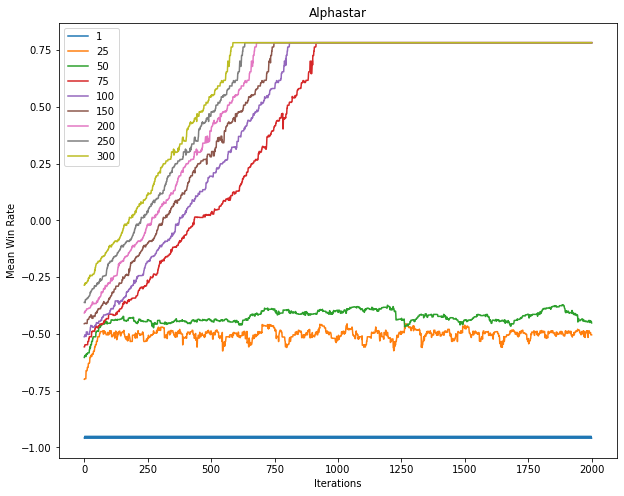

In [645]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
win_rates_results = generate_training_data3(payoff, pop_sizes)
plot_training(win_rates_results, title, pop_sizes)

### Disc Game

In [647]:
title = 'Disc Game'
payoff = payoffs['Disc game']
marker = np.ones(payoff.shape)
payoff.shape

(1000, 1000)

In [648]:
nash_clusters, markers_instances, unsolved_cases = Nash_Clustering(payoff, marker)

Iteration 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 0
Payoff remaining size 1000


In [660]:
rpp_tuples, rpp_sign_tuples, rpp_mat = generate_RPP_data(nash_clusters, payoff)
adj, strat_winrate = generate_RPS_data(payoff)

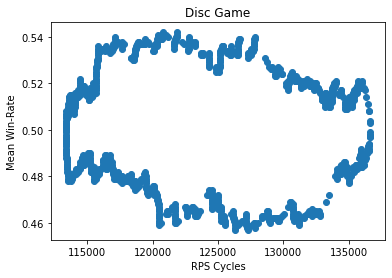

In [661]:
plot_RPS(adj, strat_winrate, title)

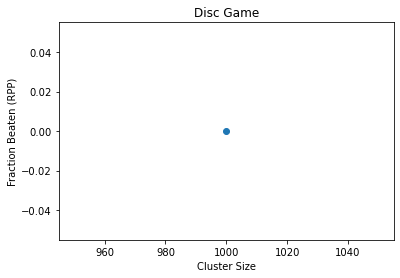

In [666]:
plot_nash_clusters_2(rpp_sign_tuples, title)

Population Size 1
Population size 1 doesn't converge
Population Size 25
Population size 25 doesn't converge
Population Size 50
Population size 50 doesn't converge
Population Size 75
Population size 75 doesn't converge
Population Size 100
Population size 100 doesn't converge
Population Size 150
Population size 150 doesn't converge
Population Size 200
Population size 200 doesn't converge
Population Size 250
Population size 250 doesn't converge
Population Size 300
Population size 300 doesn't converge


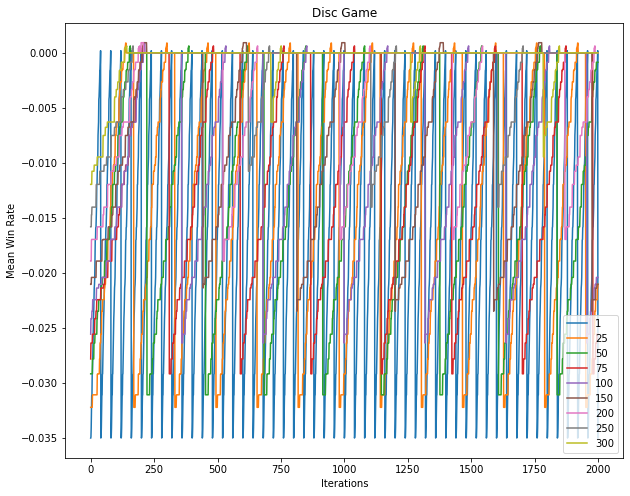

In [667]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
win_rates_results = generate_training_data3(payoff, pop_sizes)
plot_training(win_rates_results, title, pop_sizes)

### Elo Rating

In [672]:
title = 'Elo Game'
payoff = payoffs['Elo game']
marker = np.ones(payoff.shape)
payoff.shape

(1000, 1000)

In [673]:
nash_clusters, markers_instances, unsolved_cases = Nash_Clustering(payoff, marker)

Iteration 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 999
Payoff remaining size 999
Iteration 1
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 998
Payoff remaining size 998
Iteration 2
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 997
Payoff remaining size 997
Iteration 3
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 996
Payoff remaining size 996
Iteration 4
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 995
Payoff remaining size 995
Iteration 5
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 994
Payoff remaining size 994
Iteration 6
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 993
Payoff remaining size 993
Iteration 7
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 992
Payoff remaining size 992
Iteration 8
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 991
Payoff remaining size 991
Iteration 9
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 990
Payoff remaining size 990


Strategies left 918
Payoff remaining size 918
Iteration 82
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 917
Payoff remaining size 917
Iteration 83
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 916
Payoff remaining size 916
Iteration 84
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 915
Payoff remaining size 915
Iteration 85
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 914
Payoff remaining size 914
Iteration 86
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 913
Payoff remaining size 913
Iteration 87
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 912
Payoff remaining size 912
Iteration 88
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 911
Payoff remaining size 911
Iteration 89
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 910
Payoff remaining size 910
Iteration 90
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 909
Payoff remaining size 909
Iteration 91
Outside, diff = 0
APPENDING UNSO

Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 837
Payoff remaining size 837
Iteration 163
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 836
Payoff remaining size 836
Iteration 164
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 835
Payoff remaining size 835
Iteration 165
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 834
Payoff remaining size 834
Iteration 166
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 833
Payoff remaining size 833
Iteration 167
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 832
Payoff remaining size 832
Iteration 168
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 831
Payoff remaining size 831
Iteration 169
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 830
Payoff remaining size 830
Iteration 170
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 829
Payoff remaining size 829
Iteration 171
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 828
Payoff remaining siz

Strategies left 757
Payoff remaining size 757
Iteration 243
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 756
Payoff remaining size 756
Iteration 244
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 755
Payoff remaining size 755
Iteration 245
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 754
Payoff remaining size 754
Iteration 246
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 753
Payoff remaining size 753
Iteration 247
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 752
Payoff remaining size 752
Iteration 248
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 751
Payoff remaining size 751
Iteration 249
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 750
Payoff remaining size 750
Iteration 250
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 749
Payoff remaining size 749
Iteration 251
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 748
Payoff remaining size 748
Iteration 252
Outside, diff = 0
APPE

Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 676
Payoff remaining size 676
Iteration 324
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 675
Payoff remaining size 675
Iteration 325
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 674
Payoff remaining size 674
Iteration 326
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 673
Payoff remaining size 673
Iteration 327
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 672
Payoff remaining size 672
Iteration 328
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 671
Payoff remaining size 671
Iteration 329
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 670
Payoff remaining size 670
Iteration 330
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 669
Payoff remaining size 669
Iteration 331
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 668
Payoff remaining size 668
Iteration 332
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 667
Payoff remaining siz

Strategies left 596
Payoff remaining size 596
Iteration 404
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 595
Payoff remaining size 595
Iteration 405
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 594
Payoff remaining size 594
Iteration 406
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 593
Payoff remaining size 593
Iteration 407
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 592
Payoff remaining size 592
Iteration 408
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 591
Payoff remaining size 591
Iteration 409
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 590
Payoff remaining size 590
Iteration 410
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 589
Payoff remaining size 589
Iteration 411
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 588
Payoff remaining size 588
Iteration 412
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 587
Payoff remaining size 587
Iteration 413
Outside, diff = 0
APPE

APPENDING UNSOLVED CASE
Strategies left 515
Payoff remaining size 515
Iteration 485
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 514
Payoff remaining size 514
Iteration 486
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 513
Payoff remaining size 513
Iteration 487
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 512
Payoff remaining size 512
Iteration 488
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 511
Payoff remaining size 511
Iteration 489
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 510
Payoff remaining size 510
Iteration 490
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 509
Payoff remaining size 509
Iteration 491
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 508
Payoff remaining size 508
Iteration 492
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 507
Payoff remaining size 507
Iteration 493
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 506
Payoff remaining size 506
Iteration 49

Strategies left 434
Payoff remaining size 434
Iteration 566
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 433
Payoff remaining size 433
Iteration 567
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 432
Payoff remaining size 432
Iteration 568
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 431
Payoff remaining size 431
Iteration 569
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 430
Payoff remaining size 430
Iteration 570
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 429
Payoff remaining size 429
Iteration 571
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 428
Payoff remaining size 428
Iteration 572
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 427
Payoff remaining size 427
Iteration 573
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 426
Payoff remaining size 426
Iteration 574
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 425
Payoff remaining size 425
Iteration 575
Outside, diff = 0
APPE

Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 352
Payoff remaining size 352
Iteration 648
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 351
Payoff remaining size 351
Iteration 649
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 350
Payoff remaining size 350
Iteration 650
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 349
Payoff remaining size 349
Iteration 651
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 348
Payoff remaining size 348
Iteration 652
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 347
Payoff remaining size 347
Iteration 653
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 346
Payoff remaining size 346
Iteration 654
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 345
Payoff remaining size 345
Iteration 655
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 344
Payoff remaining size 344
Iteration 656
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 343
Payoff remaining siz

Strategies left 272
Payoff remaining size 272
Iteration 728
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 271
Payoff remaining size 271
Iteration 729
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 270
Payoff remaining size 270
Iteration 730
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 269
Payoff remaining size 269
Iteration 731
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 268
Payoff remaining size 268
Iteration 732
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 267
Payoff remaining size 267
Iteration 733
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 266
Payoff remaining size 266
Iteration 734
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 265
Payoff remaining size 265
Iteration 735
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 264
Payoff remaining size 264
Iteration 736
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 263
Payoff remaining size 263
Iteration 737
Outside, diff = 0
APPE

Strategies left 189
Payoff remaining size 189
Iteration 811
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 188
Payoff remaining size 188
Iteration 812
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 187
Payoff remaining size 187
Iteration 813
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 186
Payoff remaining size 186
Iteration 814
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 185
Payoff remaining size 185
Iteration 815
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 184
Payoff remaining size 184
Iteration 816
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 183
Payoff remaining size 183
Iteration 817
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 182
Payoff remaining size 182
Iteration 818
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 181
Payoff remaining size 181
Iteration 819
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 180
Payoff remaining size 180
Iteration 820
Outside, diff = 0
APPE

Strategies left 108
Payoff remaining size 108
Iteration 892
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 107
Payoff remaining size 107
Iteration 893
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 106
Payoff remaining size 106
Iteration 894
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 105
Payoff remaining size 105
Iteration 895
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 104
Payoff remaining size 104
Iteration 896
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 103
Payoff remaining size 103
Iteration 897
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 102
Payoff remaining size 102
Iteration 898
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 101
Payoff remaining size 101
Iteration 899
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 100
Payoff remaining size 100
Iteration 900
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 99
Payoff remaining size 99
Iteration 901
Outside, diff = 0
APPEND

Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 19
Payoff remaining size 19
Iteration 981
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 18
Payoff remaining size 18
Iteration 982
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 17
Payoff remaining size 17
Iteration 983
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 16
Payoff remaining size 16
Iteration 984
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 15
Payoff remaining size 15
Iteration 985
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 14
Payoff remaining size 14
Iteration 986
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 13
Payoff remaining size 13
Iteration 987
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 12
Payoff remaining size 12
Iteration 988
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 11
Payoff remaining size 11
Iteration 989
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 10
Payoff remaining size 10
Iteration 990


In [674]:
rpp_tuples, rpp_sign_tuples, rpp_mat = generate_RPP_data(nash_clusters, payoff)
adj, strat_winrate = generate_RPS_data(payoff)

<AxesSubplot:title={'center':'Elo Game RPP'}>

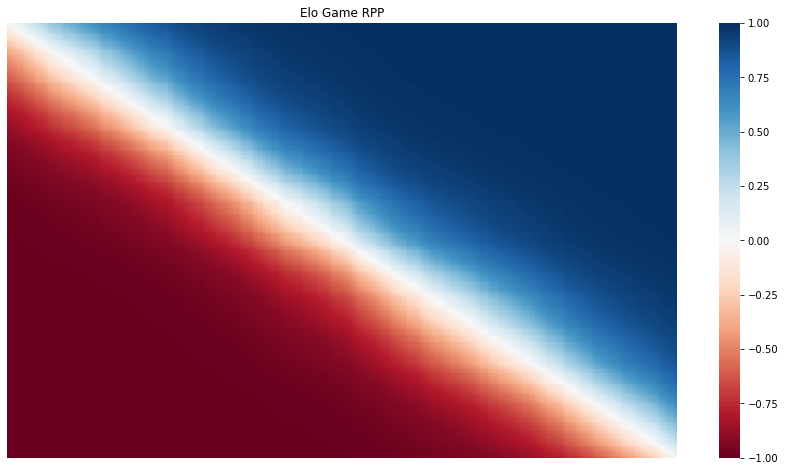

In [675]:
plt.figure(figsize = (15,8))
plt.title(title + " RPP")
sb.heatmap(rpp_mat, cmap = 'RdBu', xticklabels = False, yticklabels = False, annot = False)

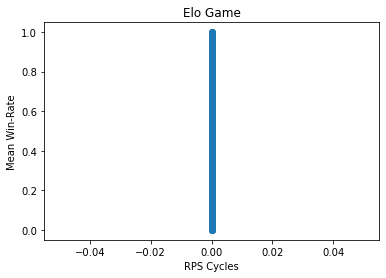

In [676]:
plot_RPS(adj, strat_winrate, title)

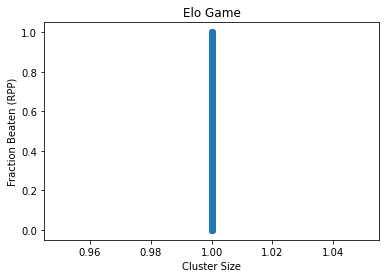

In [677]:
plot_nash_clusters_2(rpp_sign_tuples, title)

Population Size 1
First Reached Peak at 999
Population Size 25
First Reached Peak at 975
Population Size 50
First Reached Peak at 950
Population Size 75
First Reached Peak at 925
Population Size 100
First Reached Peak at 900
Population Size 150
First Reached Peak at 850
Population Size 200
First Reached Peak at 800
Population Size 250
First Reached Peak at 750
Population Size 300
First Reached Peak at 700


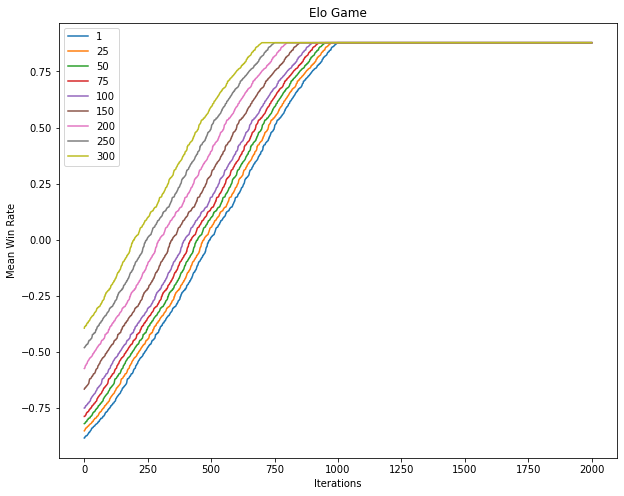

In [680]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
win_rates_results = generate_training_data3(payoff, pop_sizes)
plot_training(win_rates_results, title, pop_sizes)

### Blotto

In [672]:
title = 'Blotto'
payoff = payoffs['Blotto']
marker = np.ones(payoff.shape)
payoff.shape

(1000, 1000)

In [673]:
nash_clusters, markers_instances, unsolved_cases = Nash_Clustering(payoff, marker)

Iteration 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 999
Payoff remaining size 999
Iteration 1
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 998
Payoff remaining size 998
Iteration 2
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 997
Payoff remaining size 997
Iteration 3
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 996
Payoff remaining size 996
Iteration 4
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 995
Payoff remaining size 995
Iteration 5
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 994
Payoff remaining size 994
Iteration 6
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 993
Payoff remaining size 993
Iteration 7
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 992
Payoff remaining size 992
Iteration 8
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 991
Payoff remaining size 991
Iteration 9
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 990
Payoff remaining size 990


Strategies left 918
Payoff remaining size 918
Iteration 82
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 917
Payoff remaining size 917
Iteration 83
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 916
Payoff remaining size 916
Iteration 84
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 915
Payoff remaining size 915
Iteration 85
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 914
Payoff remaining size 914
Iteration 86
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 913
Payoff remaining size 913
Iteration 87
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 912
Payoff remaining size 912
Iteration 88
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 911
Payoff remaining size 911
Iteration 89
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 910
Payoff remaining size 910
Iteration 90
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 909
Payoff remaining size 909
Iteration 91
Outside, diff = 0
APPENDING UNSO

Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 837
Payoff remaining size 837
Iteration 163
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 836
Payoff remaining size 836
Iteration 164
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 835
Payoff remaining size 835
Iteration 165
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 834
Payoff remaining size 834
Iteration 166
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 833
Payoff remaining size 833
Iteration 167
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 832
Payoff remaining size 832
Iteration 168
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 831
Payoff remaining size 831
Iteration 169
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 830
Payoff remaining size 830
Iteration 170
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 829
Payoff remaining size 829
Iteration 171
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 828
Payoff remaining siz

Strategies left 757
Payoff remaining size 757
Iteration 243
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 756
Payoff remaining size 756
Iteration 244
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 755
Payoff remaining size 755
Iteration 245
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 754
Payoff remaining size 754
Iteration 246
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 753
Payoff remaining size 753
Iteration 247
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 752
Payoff remaining size 752
Iteration 248
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 751
Payoff remaining size 751
Iteration 249
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 750
Payoff remaining size 750
Iteration 250
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 749
Payoff remaining size 749
Iteration 251
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 748
Payoff remaining size 748
Iteration 252
Outside, diff = 0
APPE

Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 676
Payoff remaining size 676
Iteration 324
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 675
Payoff remaining size 675
Iteration 325
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 674
Payoff remaining size 674
Iteration 326
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 673
Payoff remaining size 673
Iteration 327
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 672
Payoff remaining size 672
Iteration 328
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 671
Payoff remaining size 671
Iteration 329
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 670
Payoff remaining size 670
Iteration 330
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 669
Payoff remaining size 669
Iteration 331
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 668
Payoff remaining size 668
Iteration 332
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 667
Payoff remaining siz

Strategies left 596
Payoff remaining size 596
Iteration 404
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 595
Payoff remaining size 595
Iteration 405
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 594
Payoff remaining size 594
Iteration 406
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 593
Payoff remaining size 593
Iteration 407
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 592
Payoff remaining size 592
Iteration 408
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 591
Payoff remaining size 591
Iteration 409
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 590
Payoff remaining size 590
Iteration 410
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 589
Payoff remaining size 589
Iteration 411
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 588
Payoff remaining size 588
Iteration 412
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 587
Payoff remaining size 587
Iteration 413
Outside, diff = 0
APPE

APPENDING UNSOLVED CASE
Strategies left 515
Payoff remaining size 515
Iteration 485
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 514
Payoff remaining size 514
Iteration 486
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 513
Payoff remaining size 513
Iteration 487
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 512
Payoff remaining size 512
Iteration 488
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 511
Payoff remaining size 511
Iteration 489
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 510
Payoff remaining size 510
Iteration 490
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 509
Payoff remaining size 509
Iteration 491
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 508
Payoff remaining size 508
Iteration 492
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 507
Payoff remaining size 507
Iteration 493
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 506
Payoff remaining size 506
Iteration 49

Strategies left 434
Payoff remaining size 434
Iteration 566
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 433
Payoff remaining size 433
Iteration 567
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 432
Payoff remaining size 432
Iteration 568
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 431
Payoff remaining size 431
Iteration 569
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 430
Payoff remaining size 430
Iteration 570
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 429
Payoff remaining size 429
Iteration 571
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 428
Payoff remaining size 428
Iteration 572
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 427
Payoff remaining size 427
Iteration 573
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 426
Payoff remaining size 426
Iteration 574
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 425
Payoff remaining size 425
Iteration 575
Outside, diff = 0
APPE

Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 352
Payoff remaining size 352
Iteration 648
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 351
Payoff remaining size 351
Iteration 649
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 350
Payoff remaining size 350
Iteration 650
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 349
Payoff remaining size 349
Iteration 651
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 348
Payoff remaining size 348
Iteration 652
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 347
Payoff remaining size 347
Iteration 653
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 346
Payoff remaining size 346
Iteration 654
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 345
Payoff remaining size 345
Iteration 655
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 344
Payoff remaining size 344
Iteration 656
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 343
Payoff remaining siz

Strategies left 272
Payoff remaining size 272
Iteration 728
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 271
Payoff remaining size 271
Iteration 729
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 270
Payoff remaining size 270
Iteration 730
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 269
Payoff remaining size 269
Iteration 731
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 268
Payoff remaining size 268
Iteration 732
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 267
Payoff remaining size 267
Iteration 733
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 266
Payoff remaining size 266
Iteration 734
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 265
Payoff remaining size 265
Iteration 735
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 264
Payoff remaining size 264
Iteration 736
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 263
Payoff remaining size 263
Iteration 737
Outside, diff = 0
APPE

Strategies left 189
Payoff remaining size 189
Iteration 811
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 188
Payoff remaining size 188
Iteration 812
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 187
Payoff remaining size 187
Iteration 813
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 186
Payoff remaining size 186
Iteration 814
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 185
Payoff remaining size 185
Iteration 815
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 184
Payoff remaining size 184
Iteration 816
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 183
Payoff remaining size 183
Iteration 817
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 182
Payoff remaining size 182
Iteration 818
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 181
Payoff remaining size 181
Iteration 819
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 180
Payoff remaining size 180
Iteration 820
Outside, diff = 0
APPE

Strategies left 108
Payoff remaining size 108
Iteration 892
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 107
Payoff remaining size 107
Iteration 893
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 106
Payoff remaining size 106
Iteration 894
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 105
Payoff remaining size 105
Iteration 895
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 104
Payoff remaining size 104
Iteration 896
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 103
Payoff remaining size 103
Iteration 897
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 102
Payoff remaining size 102
Iteration 898
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 101
Payoff remaining size 101
Iteration 899
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 100
Payoff remaining size 100
Iteration 900
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 99
Payoff remaining size 99
Iteration 901
Outside, diff = 0
APPEND

Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 19
Payoff remaining size 19
Iteration 981
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 18
Payoff remaining size 18
Iteration 982
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 17
Payoff remaining size 17
Iteration 983
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 16
Payoff remaining size 16
Iteration 984
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 15
Payoff remaining size 15
Iteration 985
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 14
Payoff remaining size 14
Iteration 986
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 13
Payoff remaining size 13
Iteration 987
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 12
Payoff remaining size 12
Iteration 988
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 11
Payoff remaining size 11
Iteration 989
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 10
Payoff remaining size 10
Iteration 990


In [674]:
rpp_tuples, rpp_sign_tuples, rpp_mat = generate_RPP_data(nash_clusters, payoff)
adj, strat_winrate = generate_RPS_data(payoff)

<AxesSubplot:title={'center':'Elo Game RPP'}>

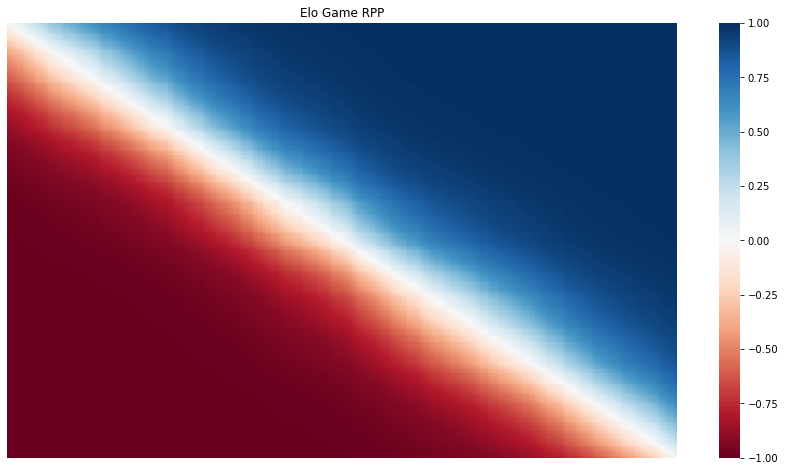

In [675]:
plt.figure(figsize = (15,8))
plt.title(title + " RPP")
sb.heatmap(rpp_mat, cmap = 'RdBu', xticklabels = False, yticklabels = False, annot = False)

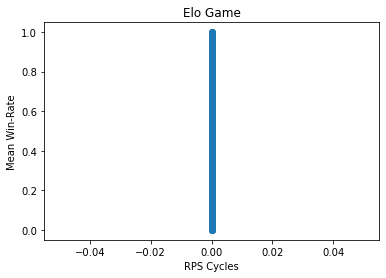

In [676]:
plot_RPS(adj, strat_winrate, title)

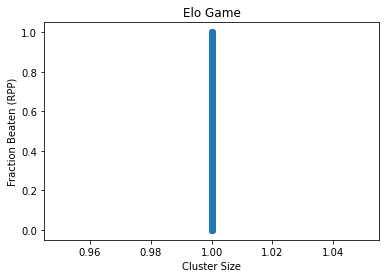

In [677]:
plot_nash_clusters_2(rpp_sign_tuples, title)

In [ ]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
win_rates_results = generate_training_data3(payoff, pop_sizes)
plot_training(win_rates_results, title, pop_sizes)

Population Size 1
First Reached Peak at 999
Population Size 25
First Reached Peak at 975
Population Size 50
First Reached Peak at 950
Population Size 75
First Reached Peak at 925
Population Size 100
First Reached Peak at 900
Population Size 150
First Reached Peak at 850
Population Size 200
First Reached Peak at 800


### Blotto

In [395]:
payoff = payoffs['Blotto']
marker = np.ones(payoff.shape)
payoff.shape

(66, 66)

In [396]:
nash_clusters, markers_instances, unsolved_cases = Nash_Clustering(payoff, marker)

Iteration 0
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 18
Payoff remaining size 18
Iteration 1
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 9
Payoff remaining size 9
Iteration 2
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 3
Payoff remaining size 3
Iteration 3
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 0
Payoff remaining size 3


In [397]:
rpp_tuples, rpp_sign_tuples, rpp_mat = generate_RPP_data(nash_clusters, payoff)
adj, strat_winrate = generate_RPS_data(payoff)

<AxesSubplot:title={'center':'10,3-Blotto RPP'}>

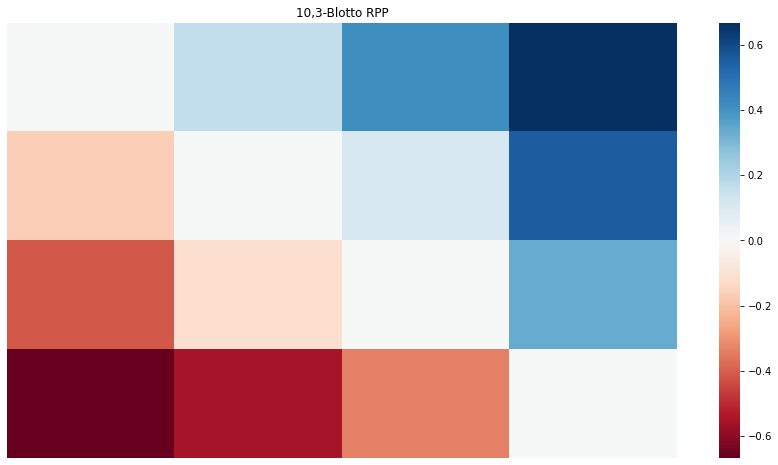

In [399]:
plt.figure(figsize = (15,8))
plt.title('10,3-Blotto RPP')
sb.heatmap(rpp_mat, cmap = 'RdBu', xticklabels = False, yticklabels = False, annot = False)

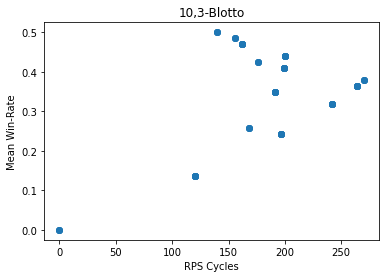

In [400]:
plot_RPS(adj, strat_winrate, '10,3-Blotto')

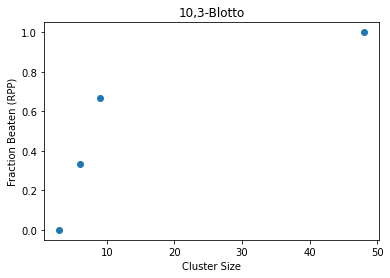

In [401]:
plot_nash_clusters_2(rpp_sign_tuples, '10,3-Blotto')

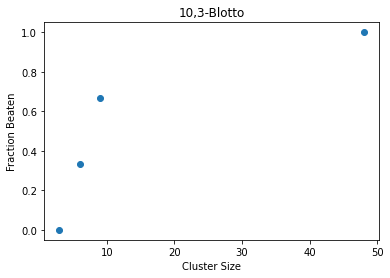

In [402]:
plot_results(nash_clusters, '10,3-Blotto')

In [403]:
y_data = rpp_sign_tuples[:, 0]; x_data = rpp_sign_tuples[:, 1]
init = np.random.uniform(1, 5, size = (5))
print(init)
params = fit_skewed_normal(init, x_data, y_data)
print(params)

[1.36584546 1.1424302  4.18931074 1.48473533 2.18881412]
[ 0.7024044   1.11905544 44.78547567 56.08055675  4.4999996 ]


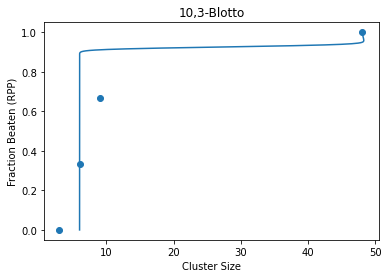

In [404]:
plot_nash_clusters_3(rpp_sign_tuples, '10,3-Blotto')

### 5,5-Blotto 

In [405]:
payoff = payoffs['5,5-Blotto']
marker = np.ones(payoff.shape)
payoff.shape

(126, 126)

In [406]:
nash_clusters, markers_instances, unsolved_cases = Nash_Clustering(payoff, marker)

Iteration 0
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 75
Payoff remaining size 75
Iteration 1
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 45
Payoff remaining size 45
Iteration 2
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 5
Payoff remaining size 5
Iteration 3
Cycle count 0, diff = 0
Outside, diff = 0
APPENDING UNSOLVED CASE
Strategies left 0
Payoff remaining size 5


In [407]:
rpp_tuples, rpp_sign_tuples, rpp_mat = generate_RPP_data(nash_clusters, payoff)
adj, strat_winrate = generate_RPS_data(payoff)

<AxesSubplot:title={'center':'10,3-Blotto RPP'}>

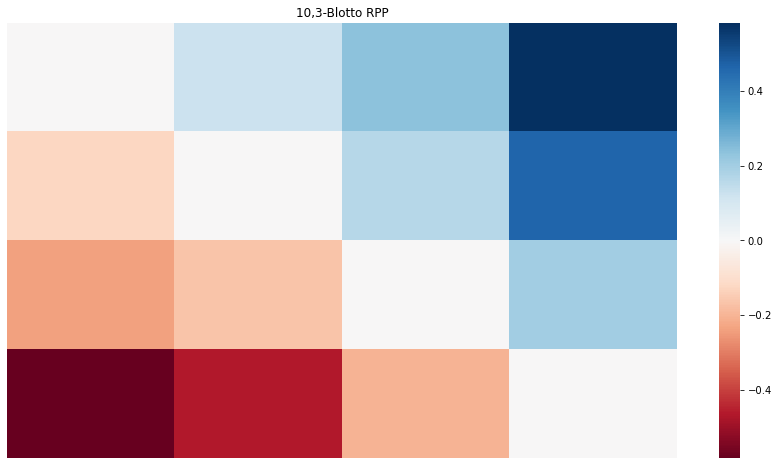

In [408]:
plt.figure(figsize = (15,8))
plt.title('5,5-Blotto RPP')
sb.heatmap(rpp_mat, cmap = 'RdBu', xticklabels = False, yticklabels = False, annot = False)

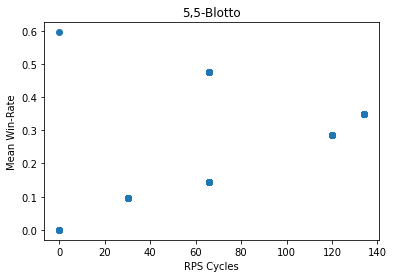

In [410]:
plot_RPS(adj, strat_winrate, '5,5-Blotto')

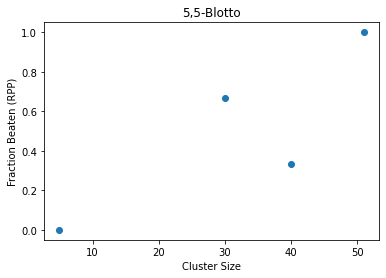

In [411]:
plot_nash_clusters_2(rpp_sign_tuples, '5,5-Blotto')

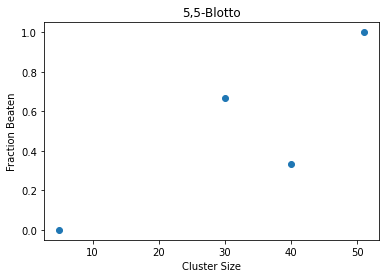

In [412]:
plot_results(nash_clusters, '5,5-Blotto')

In [417]:
y_data = rpp_sign_tuples[:, 0]; x_data = rpp_sign_tuples[:, 1]
init = np.random.uniform(1, 5, size = (5))
print(init)
params = fit_skewed_normal(init, x_data, y_data)
print(params)

[3.55015468 1.15355422 2.39675821 1.58570621 3.91450833]
[ 3.54995004  1.15438943  2.39655357  1.58566623 31.50010055]


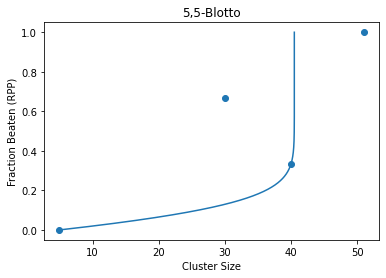

In [418]:
plot_nash_clusters_3(rpp_sign_tuples, '5,5-Blotto')

### Tic Tac Toe Training Plots test

In [504]:
payoff = payoffs['go(board_size=3,komi=6.5)']
payoff.shape

(1933, 1933)

In [435]:
def compute_win_rate(curr_idx, payoff):
    return np.mean(payoff[curr_idx, :])

In [367]:
# pop_size = 200; win_rates = []
# strat_strengths = np.mean(payoff, axis = 1)
# ordering_idx = np.argsort(strat_strengths)

# curr_strat_idx = list(ordering_idx[:pop_size])
# taken_idx = np.array(list(itertools.product(curr_strat_idx, repeat = 2)))
# mini_payoff = payoff[taken_idx[:,0], taken_idx[:, 1]].reshape(len(curr_strat_idx), len(curr_strat_idx))

# allocation, _ = solve_MaxEnt_NE(mini_payoff)

Cycle count 0, diff = 0


In [375]:
# p_vect = np.zeros((payoff.shape[0]))
# p_vect[curr_strat_idx] = allocation

# np.mean(payoff @ p_vect.reshape(-1, 1))

0.39480796045651556

In [510]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
win_rates_results = []

for pop_size in pop_sizes:
    print(f"Population Size {pop_size}")
    win_rates = []
    strat_strengths = np.mean(payoff, axis = 1)
    ordering_idx = np.argsort(strat_strengths)

    curr_strat_idx = list(ordering_idx[:pop_size])
    win_rates.append(compute_win_rate(curr_strat_idx, payoff))
    n_iters = 2000; it = 0
    converge = False
    while it < n_iters:
        taken_payoff = np.sum(payoff[:, curr_strat_idx], axis = 1)
        viable_strats = np.where(taken_payoff > 0)[0]
        not_in = ~np.isin(viable_strats, curr_strat_idx)
        viable_strats = viable_strats[not_in]
        if len(viable_strats) > 0:
            viable_strengths = strat_strengths[viable_strats]
            sorted_idx = np.argsort(viable_strengths)
            new_strat = viable_strats[sorted_idx[0]]
            curr_strat_idx.append(new_strat)
            curr_strat_idx = curr_strat_idx[1:]
        else:
            if converge == False:
                converge = True
                it_conv = it
                print(f"First Reached Peak at {it_conv}")


        win_rates.append(compute_win_rate(curr_strat_idx, payoff))
        it += 1
        
    if converge == False:
        print(f"Population size {pop_size} doesn't converge")
    win_rates_results.append(win_rates)
    
    

Population Size 1
Population size 1 doesn't converge
Population Size 25
Population size 25 doesn't converge
Population Size 50
Population size 50 doesn't converge
Population Size 75
Population size 75 doesn't converge
Population Size 100
Population size 100 doesn't converge
Population Size 150
Population size 150 doesn't converge
Population Size 200
Population size 200 doesn't converge
Population Size 250
First Reached Peak at 1786
Population Size 300
First Reached Peak at 1678


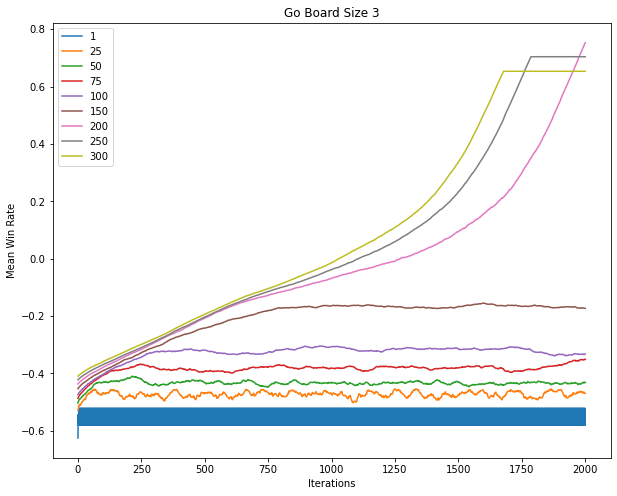

In [517]:
plt.figure(figsize = (10,8))
plt.title('Go Board Size 3')
for idx, win_rates in enumerate(win_rates_results):
    plt.plot(np.arange(len(win_rates)), win_rates, label = str(pop_sizes[idx]))
plt.xlabel('Iterations')
plt.ylabel('Mean Win Rate')
plt.legend()